<div align="center">
    <font color="0F5298" size="7">
        Deep Learning <br>
    </font>
    <font color="2565AE" size="5">
        CE Department <br>
        Spring 2024 - Prof. Soleymani Baghshah <br>
    </font>
    <font color="3C99D" size="5">
        HW2 Practical <br>
    </font>
    <font color="696880" size="5">
        30 Points
    </font>
</div>


In [40]:
FULLNAME = 'Nikan Vasei'
STD_ID = '400105303'

In this notebook, we aim to perform **classification** on images from the **CIFAR10** dataset using CNN networks. First, we load the dataset and apply the necessary transformations for normalization and augmentation. After that, we visualize some samples. Once we familiarize ourselves with the dataset, we proceed to design the desired convolutional network, which is explained in the relevant section. After designing the model, we move on to training and evaluating it. At the end of the first section, we analyze the feature space from different perspectives. First, using the KNN method, we examine the closest samples to each other in the feature space. Then, we cluster the data and finally visualize the outputs of the intermediate layers of the model.

In the second part of the notebook, we perform a simple transfer learning task on the trained model from the first section but using a new dataset, **CIFAR100**. To do this, we modify the final layer of the network and retrain it. Further details are provided in the relevant section. Finally, we evaluate the model’s accuracy on the new task and analyze the extracted features and how well the model generalizes. After designing and training the model, we will further analyze the extracted feature space. Finally, we will evaluate the generalization ability of the model and its extracted features on a new dataset,

# CIFAR10 Classification

## Import Libraries

Import needed libraries

In [41]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import tqdm
from time import time
import random
from sklearn.manifold import TSNE
import numpy as np
from random import sample
import math
import torch.optim as optim
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE

## Device

Set device to work with (GPU or CPU)

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [43]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [44]:
# TODO: Data Transforms

mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# TODO: Load Train Data

dataset_raw = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

dataset_trainval = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

# TODO: Split Train and Validation Data

train_size = int(0.8 * len(dataset_trainval))

dataset_train, dataset_val = random_split(dataset_trainval, [train_size, len(dataset_trainval) - train_size])

# TODO: Load Test Data

dataset_test = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

# TODO: Define Data Loaders

BATCH_SIZE = 128

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

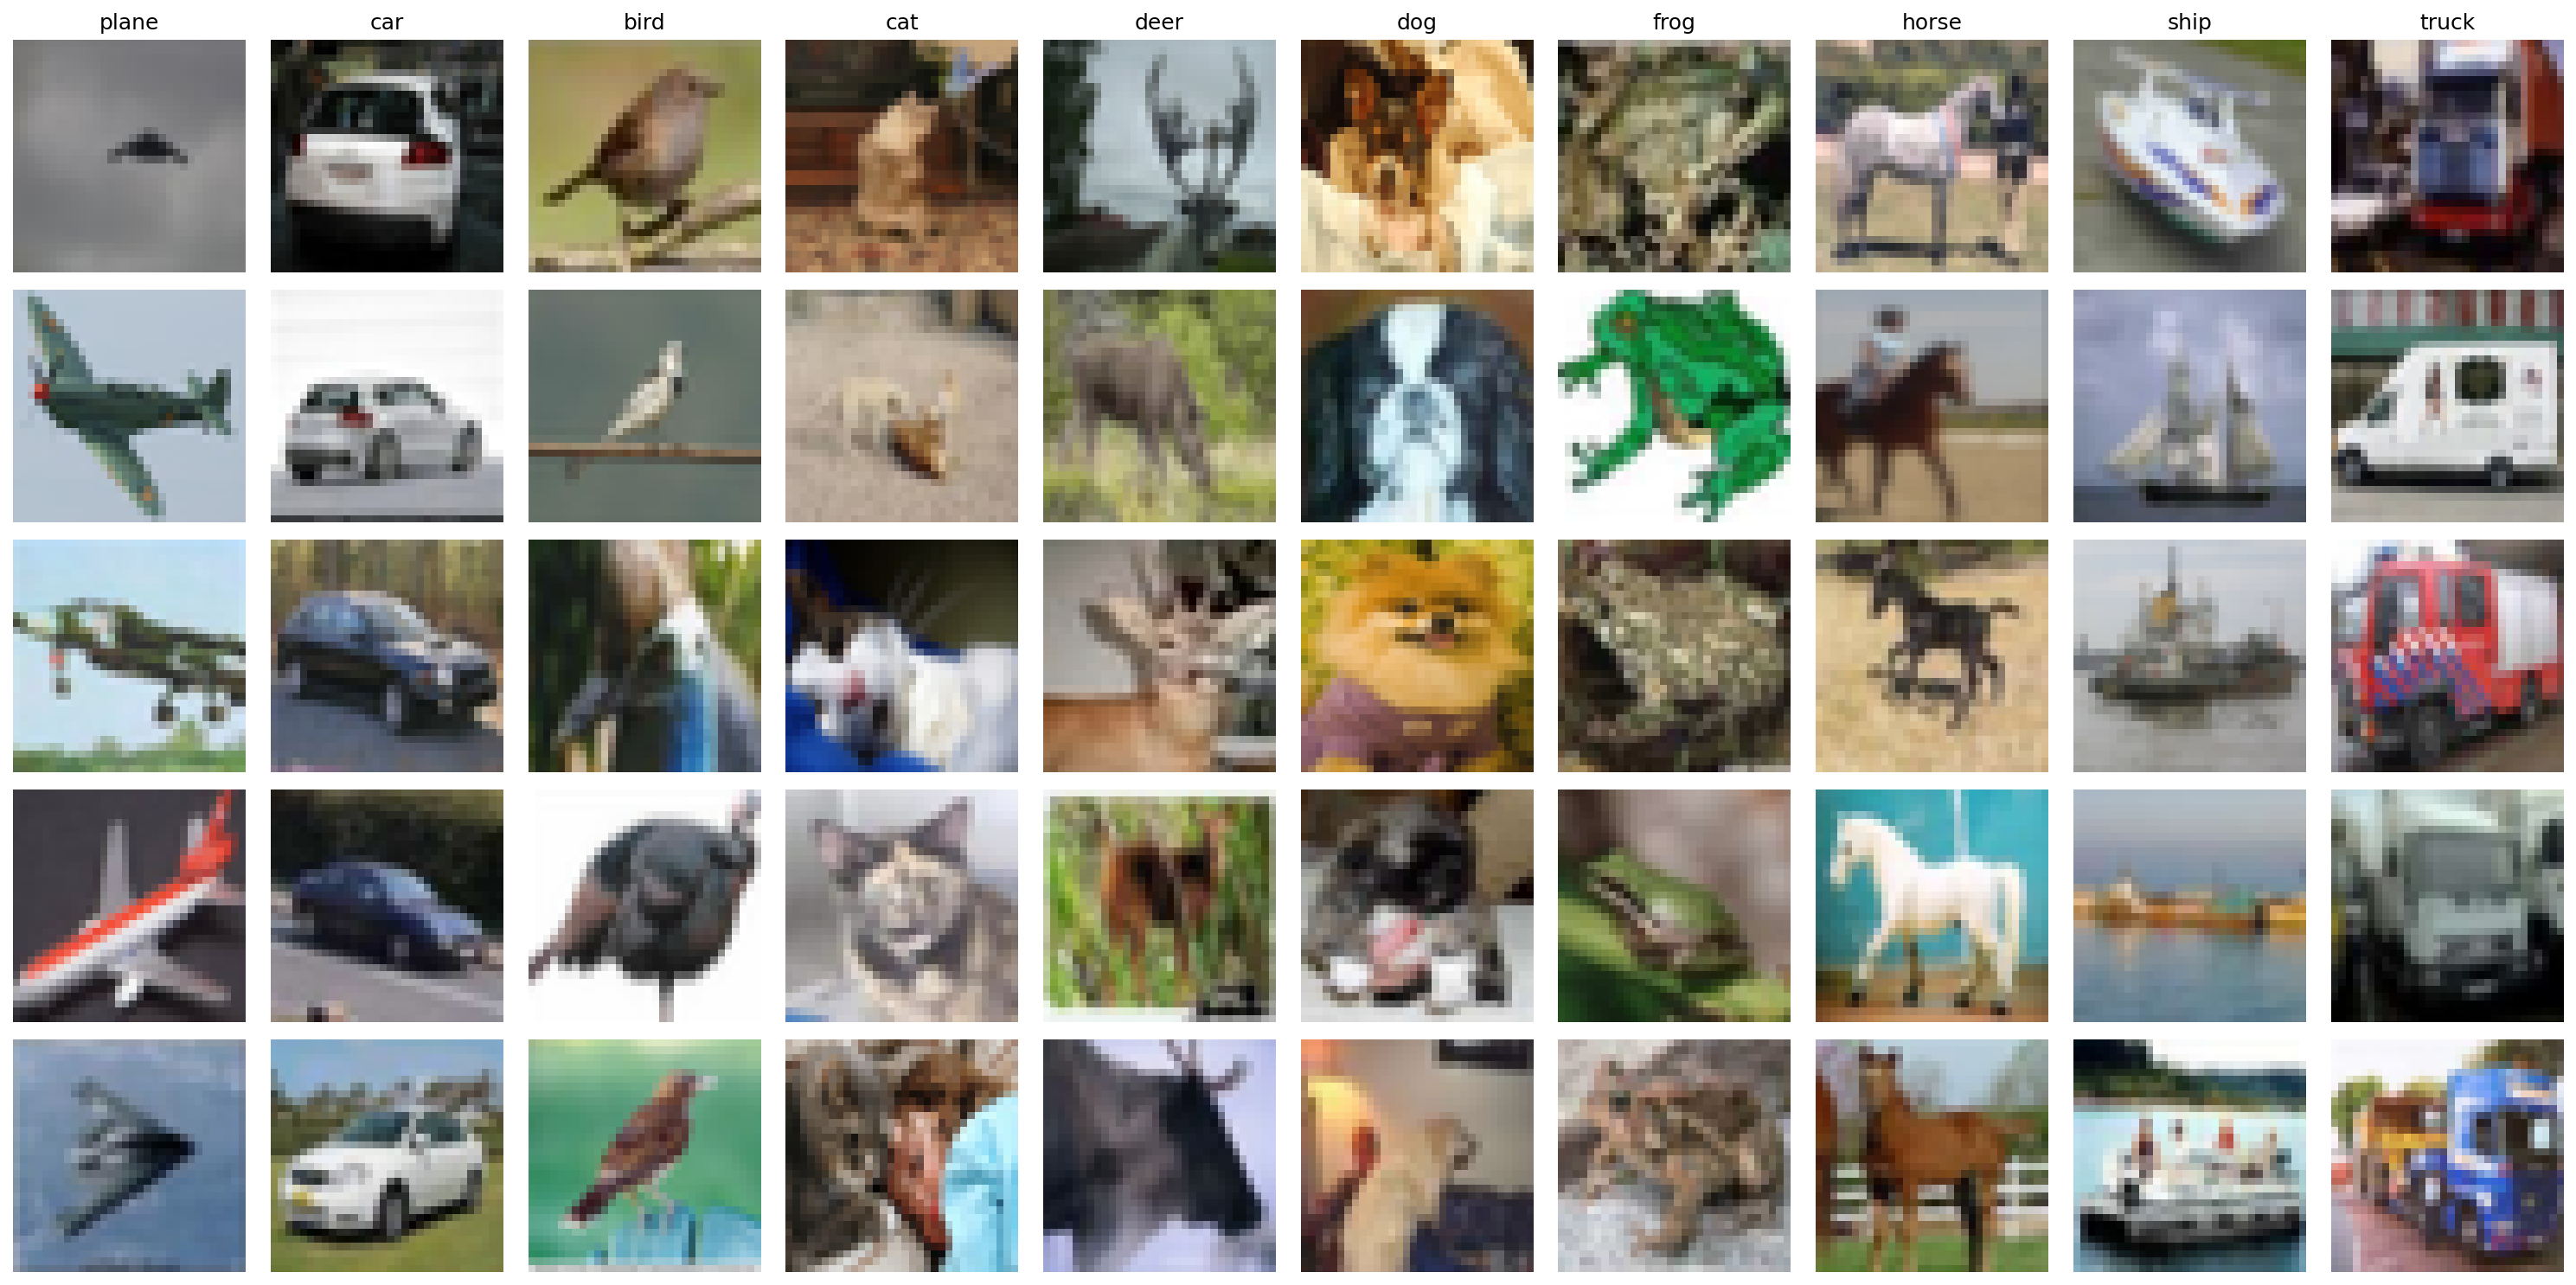

In [45]:
# TODO: Find 5 Images from Each Class

sample_image_idxs = []
for i, c in enumerate(classes):
    class_indices = [idx for idx, (_, label) in enumerate(dataset_raw) if label == i]
    sample_image_idxs.append(sample(class_indices, 5))

# Plot Images

fig, axes = plt.subplots(5, 10, figsize=(20, 10))

for idx, image_idxs in enumerate(sample_image_idxs):
    for j, img_idx in enumerate(image_idxs):
        img, label = dataset_raw[img_idx]
        axes[j, idx].imshow(img.permute(1, 2, 0).numpy())
        axes[j, idx].axis('off')
        if j == 0:
            axes[j, idx].set_title(classes[idx])

plt.tight_layout()
plt.show()

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

- **Hint I**: Our goal is to get accuracy above *90%* on testset. Our suggestion is to implement ResNet (ResNet18 could be a viable choice)
  - You can learn the network's structure and implementation online (Youtube, ...) and then implmenet it yourself and make changes to enhance it's performance on our task **(YOU SHOULD NOT COPY THE CODE!!! OTHERWISE, YOU'LL BE PENALIZED!!!)**

- **Hint II**: When defining your model, pay attension to the **NOTICE** part in the above. It's also better to read the "Exploring the feature space" section beforehand.  

In [46]:
# TODO: Implement Model

# Implemented using this tutorial on YouTube: https://www.youtube.com/watch?v=DkNIBBBvcPs
# and ResNet's original paper: https://arxiv.org/pdf/1512.03385
# The model might be similar to the one in the tutorial in some parts, but obviously I have not copied it.

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += self.shortcut(identity)
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, num_classes=10, feature_space_size=512, image_channels=3):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.relu = nn.ReLU()

        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.feature_space = nn.Linear(512, feature_space_size)

        self.fc = nn.Linear(feature_space_size, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []

        layers.append(ResNetBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResNetBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        x = self.feature_space(x)

        out = self.fc(x)
        return out, x

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [55]:
# TODO: Define Model
model = ResNet(num_classes=10, feature_space_size=512).to(device)

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [56]:
# TODO: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

### Train loop

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [57]:
# TODO: Implement Training Loop

def train_loop(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm.tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs, _ = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    return epoch_loss, epoch_accuracy

In [58]:
# TODO: Implement Validation Loop

def val_loop(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm.tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)

            outputs, _ = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = 100 * correct / total

    return epoch_loss, epoch_accuracy

In [59]:
# TODO: Train The Model

EPOCHS = 80

best_val_accuracy = 0.0
patience = 10
counter = 0

train_accuracy_list = []
train_loss_list = []
val_accuracy_list = []
val_loss_list = []

for epoch in range(EPOCHS):
    train_loss, train_accuracy = train_loop(model, train_loader, criterion, optimizer, scheduler)
    val_loss, val_accuracy = val_loop(model, val_loader, criterion)

    if val_accuracy > best_val_accuracy:
        best_val_acc = val_accuracy
        counter = 0
        torch.save(model.state_dict(), 'cifar10_NikanVasei.pth')
    else:
        counter += 1

    if counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%\n"
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n"
          f"Epoch [{epoch+1}/{EPOCHS}], ")

100%|██████████| 79/79 [00:05<00:00, 13.21it/s]


Train Loss: 1.8120, Train Accuracy: 32.50%
Validation Loss: 1.5702, Validation Accuracy: 40.77%
Epoch [1/80], 


100%|██████████| 79/79 [00:05<00:00, 15.57it/s]


Train Loss: 1.4965, Train Accuracy: 44.91%
Validation Loss: 1.4116, Validation Accuracy: 48.44%
Epoch [2/80], 


100%|██████████| 79/79 [00:04<00:00, 19.16it/s]


Train Loss: 1.3036, Train Accuracy: 52.89%
Validation Loss: 1.2451, Validation Accuracy: 55.38%
Epoch [3/80], 


100%|██████████| 79/79 [00:04<00:00, 18.38it/s]


Train Loss: 1.1460, Train Accuracy: 58.84%
Validation Loss: 1.2436, Validation Accuracy: 56.83%
Epoch [4/80], 


100%|██████████| 79/79 [00:04<00:00, 17.48it/s]


Train Loss: 1.0145, Train Accuracy: 64.22%
Validation Loss: 1.0840, Validation Accuracy: 61.82%
Epoch [5/80], 


100%|██████████| 79/79 [00:04<00:00, 17.89it/s]


Train Loss: 0.9048, Train Accuracy: 68.39%
Validation Loss: 0.9245, Validation Accuracy: 68.11%
Epoch [6/80], 


100%|██████████| 79/79 [00:04<00:00, 18.10it/s]


Train Loss: 0.8347, Train Accuracy: 71.08%
Validation Loss: 0.9068, Validation Accuracy: 68.13%
Epoch [7/80], 


100%|██████████| 79/79 [00:05<00:00, 14.41it/s]


Train Loss: 0.7718, Train Accuracy: 73.53%
Validation Loss: 0.8362, Validation Accuracy: 71.53%
Epoch [8/80], 


100%|██████████| 79/79 [00:04<00:00, 18.59it/s]


Train Loss: 0.7339, Train Accuracy: 74.63%
Validation Loss: 0.8285, Validation Accuracy: 71.62%
Epoch [9/80], 


100%|██████████| 79/79 [00:04<00:00, 18.59it/s]


Train Loss: 0.6920, Train Accuracy: 76.17%
Validation Loss: 0.7657, Validation Accuracy: 73.51%
Epoch [10/80], 


100%|██████████| 79/79 [00:04<00:00, 18.84it/s]


Train Loss: 0.6658, Train Accuracy: 77.26%
Validation Loss: 0.7921, Validation Accuracy: 72.32%
Epoch [11/80], 


100%|██████████| 79/79 [00:04<00:00, 18.15it/s]


Train Loss: 0.6449, Train Accuracy: 78.21%
Validation Loss: 0.7037, Validation Accuracy: 75.97%
Epoch [12/80], 


100%|██████████| 79/79 [00:04<00:00, 18.02it/s]


Train Loss: 0.6273, Train Accuracy: 78.59%
Validation Loss: 0.7262, Validation Accuracy: 75.62%
Epoch [13/80], 


100%|██████████| 79/79 [00:04<00:00, 18.76it/s]


Train Loss: 0.6150, Train Accuracy: 78.89%
Validation Loss: 0.7779, Validation Accuracy: 73.47%
Epoch [14/80], 


100%|██████████| 79/79 [00:04<00:00, 18.04it/s]


Train Loss: 0.5988, Train Accuracy: 79.52%
Validation Loss: 0.7128, Validation Accuracy: 76.12%
Epoch [15/80], 


100%|██████████| 79/79 [00:04<00:00, 18.36it/s]


Train Loss: 0.5952, Train Accuracy: 79.72%
Validation Loss: 0.8100, Validation Accuracy: 72.73%
Epoch [16/80], 


100%|██████████| 79/79 [00:04<00:00, 18.64it/s]


Train Loss: 0.5781, Train Accuracy: 80.31%
Validation Loss: 0.6933, Validation Accuracy: 76.77%
Epoch [17/80], 


100%|██████████| 79/79 [00:05<00:00, 15.21it/s]


Train Loss: 0.5659, Train Accuracy: 80.70%
Validation Loss: 0.8629, Validation Accuracy: 72.70%
Epoch [18/80], 


100%|██████████| 79/79 [00:05<00:00, 14.45it/s]


Train Loss: 0.5576, Train Accuracy: 81.12%
Validation Loss: 0.7462, Validation Accuracy: 75.48%
Epoch [19/80], 


100%|██████████| 79/79 [00:05<00:00, 14.81it/s]


Train Loss: 0.5489, Train Accuracy: 81.38%
Validation Loss: 0.8608, Validation Accuracy: 71.80%
Epoch [20/80], 


100%|██████████| 79/79 [00:05<00:00, 14.86it/s]


Train Loss: 0.5454, Train Accuracy: 81.36%
Validation Loss: 0.7308, Validation Accuracy: 76.40%
Epoch [21/80], 


100%|██████████| 79/79 [00:05<00:00, 14.91it/s]


Train Loss: 0.5394, Train Accuracy: 81.82%
Validation Loss: 0.6312, Validation Accuracy: 79.15%
Epoch [22/80], 


100%|██████████| 79/79 [00:04<00:00, 15.93it/s]


Train Loss: 0.5281, Train Accuracy: 82.29%
Validation Loss: 0.7186, Validation Accuracy: 76.05%
Epoch [23/80], 


100%|██████████| 79/79 [00:04<00:00, 16.70it/s]


Train Loss: 0.5296, Train Accuracy: 81.90%
Validation Loss: 0.6855, Validation Accuracy: 76.91%
Epoch [24/80], 


100%|██████████| 79/79 [00:04<00:00, 17.97it/s]


Train Loss: 0.5189, Train Accuracy: 82.37%
Validation Loss: 0.7655, Validation Accuracy: 74.66%
Epoch [25/80], 


100%|██████████| 79/79 [00:04<00:00, 17.69it/s]


Train Loss: 0.5271, Train Accuracy: 82.21%
Validation Loss: 0.6050, Validation Accuracy: 79.93%
Epoch [26/80], 


100%|██████████| 79/79 [00:04<00:00, 17.33it/s]


Train Loss: 0.5157, Train Accuracy: 82.62%
Validation Loss: 0.5756, Validation Accuracy: 80.96%
Epoch [27/80], 


100%|██████████| 79/79 [00:04<00:00, 18.27it/s]


Train Loss: 0.5073, Train Accuracy: 82.66%
Validation Loss: 0.7369, Validation Accuracy: 75.88%
Epoch [28/80], 


100%|██████████| 79/79 [00:04<00:00, 18.08it/s]


Train Loss: 0.5145, Train Accuracy: 82.52%
Validation Loss: 0.6919, Validation Accuracy: 77.43%
Epoch [29/80], 


100%|██████████| 79/79 [00:04<00:00, 17.89it/s]


Train Loss: 0.5075, Train Accuracy: 82.66%
Validation Loss: 0.6881, Validation Accuracy: 77.21%
Epoch [30/80], 


100%|██████████| 79/79 [00:04<00:00, 18.38it/s]


Train Loss: 0.3278, Train Accuracy: 88.80%
Validation Loss: 0.3692, Validation Accuracy: 87.43%
Epoch [31/80], 


100%|██████████| 79/79 [00:04<00:00, 19.03it/s]


Train Loss: 0.2670, Train Accuracy: 90.86%
Validation Loss: 0.3531, Validation Accuracy: 87.92%
Epoch [32/80], 


100%|██████████| 79/79 [00:04<00:00, 18.49it/s]


Train Loss: 0.2424, Train Accuracy: 91.58%
Validation Loss: 0.3447, Validation Accuracy: 88.07%
Epoch [33/80], 


100%|██████████| 79/79 [00:04<00:00, 18.07it/s]


Train Loss: 0.2275, Train Accuracy: 92.15%
Validation Loss: 0.3383, Validation Accuracy: 88.62%
Epoch [34/80], 


100%|██████████| 79/79 [00:04<00:00, 18.18it/s]


Train Loss: 0.2110, Train Accuracy: 92.84%
Validation Loss: 0.3381, Validation Accuracy: 88.66%
Epoch [35/80], 


100%|██████████| 79/79 [00:04<00:00, 15.83it/s]


Train Loss: 0.1969, Train Accuracy: 93.23%
Validation Loss: 0.3456, Validation Accuracy: 88.89%
Epoch [36/80], 


100%|██████████| 79/79 [00:05<00:00, 14.98it/s]


Train Loss: 0.1864, Train Accuracy: 93.50%
Validation Loss: 0.3438, Validation Accuracy: 88.59%
Epoch [37/80], 


100%|██████████| 79/79 [00:05<00:00, 14.33it/s]


Train Loss: 0.1765, Train Accuracy: 93.80%
Validation Loss: 0.3416, Validation Accuracy: 88.79%
Epoch [38/80], 


100%|██████████| 79/79 [00:05<00:00, 15.46it/s]


Train Loss: 0.1700, Train Accuracy: 94.11%
Validation Loss: 0.3405, Validation Accuracy: 88.54%
Epoch [39/80], 


100%|██████████| 79/79 [00:05<00:00, 14.96it/s]


Train Loss: 0.1617, Train Accuracy: 94.50%
Validation Loss: 0.3331, Validation Accuracy: 89.30%
Epoch [40/80], 


100%|██████████| 79/79 [00:05<00:00, 15.29it/s]


Train Loss: 0.1527, Train Accuracy: 94.65%
Validation Loss: 0.3304, Validation Accuracy: 89.21%
Epoch [41/80], 


100%|██████████| 79/79 [00:04<00:00, 16.18it/s]


Train Loss: 0.1506, Train Accuracy: 94.75%
Validation Loss: 0.3416, Validation Accuracy: 88.96%
Epoch [42/80], 


100%|██████████| 79/79 [00:04<00:00, 16.97it/s]


Train Loss: 0.1421, Train Accuracy: 94.99%
Validation Loss: 0.3549, Validation Accuracy: 89.02%
Epoch [43/80], 


100%|██████████| 79/79 [00:04<00:00, 17.72it/s]


Train Loss: 0.1339, Train Accuracy: 95.39%
Validation Loss: 0.3668, Validation Accuracy: 88.72%
Epoch [44/80], 


100%|██████████| 79/79 [00:04<00:00, 18.76it/s]


Train Loss: 0.1319, Train Accuracy: 95.33%
Validation Loss: 0.3571, Validation Accuracy: 89.06%
Epoch [45/80], 


100%|██████████| 79/79 [00:04<00:00, 18.82it/s]


Train Loss: 0.1292, Train Accuracy: 95.54%
Validation Loss: 0.3459, Validation Accuracy: 89.34%
Epoch [46/80], 


100%|██████████| 79/79 [00:04<00:00, 19.26it/s]


Train Loss: 0.1245, Train Accuracy: 95.61%
Validation Loss: 0.3532, Validation Accuracy: 89.06%
Epoch [47/80], 


100%|██████████| 79/79 [00:04<00:00, 18.55it/s]


Train Loss: 0.1207, Train Accuracy: 95.84%
Validation Loss: 0.3670, Validation Accuracy: 89.11%
Epoch [48/80], 


100%|██████████| 79/79 [00:04<00:00, 19.09it/s]


Train Loss: 0.1183, Train Accuracy: 95.87%
Validation Loss: 0.3766, Validation Accuracy: 88.52%
Epoch [49/80], 


100%|██████████| 79/79 [00:04<00:00, 17.47it/s]


Train Loss: 0.1167, Train Accuracy: 95.99%
Validation Loss: 0.3735, Validation Accuracy: 89.11%
Epoch [50/80], 


100%|██████████| 79/79 [00:04<00:00, 18.47it/s]


Train Loss: 0.1117, Train Accuracy: 96.07%
Validation Loss: 0.3627, Validation Accuracy: 89.14%
Epoch [51/80], 


100%|██████████| 79/79 [00:04<00:00, 19.18it/s]


Train Loss: 0.1102, Train Accuracy: 96.14%
Validation Loss: 0.3941, Validation Accuracy: 88.00%
Epoch [52/80], 


100%|██████████| 79/79 [00:04<00:00, 18.97it/s]


Train Loss: 0.1076, Train Accuracy: 96.22%
Validation Loss: 0.3836, Validation Accuracy: 88.70%
Epoch [53/80], 


100%|██████████| 79/79 [00:04<00:00, 18.30it/s]


Train Loss: 0.1135, Train Accuracy: 96.10%
Validation Loss: 0.4059, Validation Accuracy: 88.06%
Epoch [54/80], 


100%|██████████| 79/79 [00:04<00:00, 17.73it/s]


Train Loss: 0.1079, Train Accuracy: 96.23%
Validation Loss: 0.3764, Validation Accuracy: 88.87%
Epoch [55/80], 


100%|██████████| 79/79 [00:04<00:00, 17.67it/s]


Train Loss: 0.1040, Train Accuracy: 96.38%
Validation Loss: 0.3942, Validation Accuracy: 88.42%
Epoch [56/80], 


100%|██████████| 79/79 [00:04<00:00, 17.37it/s]


Train Loss: 0.1020, Train Accuracy: 96.41%
Validation Loss: 0.4196, Validation Accuracy: 88.23%
Epoch [57/80], 


100%|██████████| 79/79 [00:04<00:00, 19.19it/s]


Train Loss: 0.1044, Train Accuracy: 96.38%
Validation Loss: 0.4243, Validation Accuracy: 88.03%
Epoch [58/80], 


100%|██████████| 79/79 [00:04<00:00, 18.61it/s]


Train Loss: 0.1004, Train Accuracy: 96.38%
Validation Loss: 0.4017, Validation Accuracy: 88.39%
Epoch [59/80], 


100%|██████████| 79/79 [00:04<00:00, 18.44it/s]


Train Loss: 0.1060, Train Accuracy: 96.39%
Validation Loss: 0.4041, Validation Accuracy: 88.31%
Epoch [60/80], 


100%|██████████| 79/79 [00:04<00:00, 19.21it/s]


Train Loss: 0.0635, Train Accuracy: 97.90%
Validation Loss: 0.3370, Validation Accuracy: 90.19%
Epoch [61/80], 


100%|██████████| 79/79 [00:04<00:00, 19.11it/s]


Train Loss: 0.0486, Train Accuracy: 98.50%
Validation Loss: 0.3498, Validation Accuracy: 90.05%
Epoch [62/80], 


100%|██████████| 79/79 [00:04<00:00, 16.11it/s]


Train Loss: 0.0431, Train Accuracy: 98.67%
Validation Loss: 0.3435, Validation Accuracy: 90.39%
Epoch [63/80], 


100%|██████████| 79/79 [00:04<00:00, 18.88it/s]


Train Loss: 0.0386, Train Accuracy: 98.81%
Validation Loss: 0.3502, Validation Accuracy: 90.30%
Epoch [64/80], 


100%|██████████| 79/79 [00:04<00:00, 18.37it/s]


Train Loss: 0.0348, Train Accuracy: 98.88%
Validation Loss: 0.3549, Validation Accuracy: 90.51%
Epoch [65/80], 


100%|██████████| 79/79 [00:04<00:00, 18.53it/s]


Train Loss: 0.0324, Train Accuracy: 98.96%
Validation Loss: 0.3596, Validation Accuracy: 90.45%
Epoch [66/80], 


100%|██████████| 79/79 [00:04<00:00, 18.90it/s]


Train Loss: 0.0296, Train Accuracy: 99.10%
Validation Loss: 0.3613, Validation Accuracy: 90.49%
Epoch [67/80], 


100%|██████████| 79/79 [00:04<00:00, 18.75it/s]


Train Loss: 0.0287, Train Accuracy: 99.13%
Validation Loss: 0.3670, Validation Accuracy: 90.51%
Epoch [68/80], 


100%|██████████| 79/79 [00:04<00:00, 18.29it/s]


Train Loss: 0.0280, Train Accuracy: 99.13%
Validation Loss: 0.3692, Validation Accuracy: 90.44%
Epoch [69/80], 


100%|██████████| 79/79 [00:04<00:00, 18.02it/s]


Train Loss: 0.0273, Train Accuracy: 99.17%
Validation Loss: 0.3825, Validation Accuracy: 90.51%
Epoch [70/80], 


100%|██████████| 79/79 [00:04<00:00, 18.74it/s]


Train Loss: 0.0234, Train Accuracy: 99.33%
Validation Loss: 0.3831, Validation Accuracy: 90.33%
Epoch [71/80], 


100%|██████████| 79/79 [00:05<00:00, 15.51it/s]


Train Loss: 0.0248, Train Accuracy: 99.25%
Validation Loss: 0.3753, Validation Accuracy: 90.24%
Epoch [72/80], 


100%|██████████| 79/79 [00:04<00:00, 18.39it/s]


Train Loss: 0.0206, Train Accuracy: 99.38%
Validation Loss: 0.3641, Validation Accuracy: 90.66%
Epoch [73/80], 


100%|██████████| 79/79 [00:04<00:00, 18.37it/s]


Train Loss: 0.0208, Train Accuracy: 99.38%
Validation Loss: 0.3702, Validation Accuracy: 90.53%
Epoch [74/80], 


100%|██████████| 79/79 [00:04<00:00, 18.20it/s]


Train Loss: 0.0204, Train Accuracy: 99.39%
Validation Loss: 0.3731, Validation Accuracy: 90.44%
Epoch [75/80], 


100%|██████████| 79/79 [00:04<00:00, 18.43it/s]


Train Loss: 0.0197, Train Accuracy: 99.40%
Validation Loss: 0.3791, Validation Accuracy: 90.63%
Epoch [76/80], 


100%|██████████| 79/79 [00:04<00:00, 18.38it/s]


Train Loss: 0.0194, Train Accuracy: 99.36%
Validation Loss: 0.3862, Validation Accuracy: 90.45%
Epoch [77/80], 


100%|██████████| 79/79 [00:04<00:00, 18.56it/s]


Train Loss: 0.0181, Train Accuracy: 99.47%
Validation Loss: 0.4052, Validation Accuracy: 90.41%
Epoch [78/80], 


100%|██████████| 79/79 [00:04<00:00, 18.07it/s]


Train Loss: 0.0165, Train Accuracy: 99.55%
Validation Loss: 0.3928, Validation Accuracy: 90.67%
Epoch [79/80], 


100%|██████████| 79/79 [00:04<00:00, 19.63it/s]


Train Loss: 0.0172, Train Accuracy: 99.50%
Validation Loss: 0.3918, Validation Accuracy: 90.59%
Epoch [80/80], 


### Save Model

Since changes need to be made to the model later on, it is advisable to save your model to avoid having to retrain it in case of any issues.

In [60]:
# TODO: Save Model
# torch.save(model.state_dict(), "cifar10_NikanVasei.pth")

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

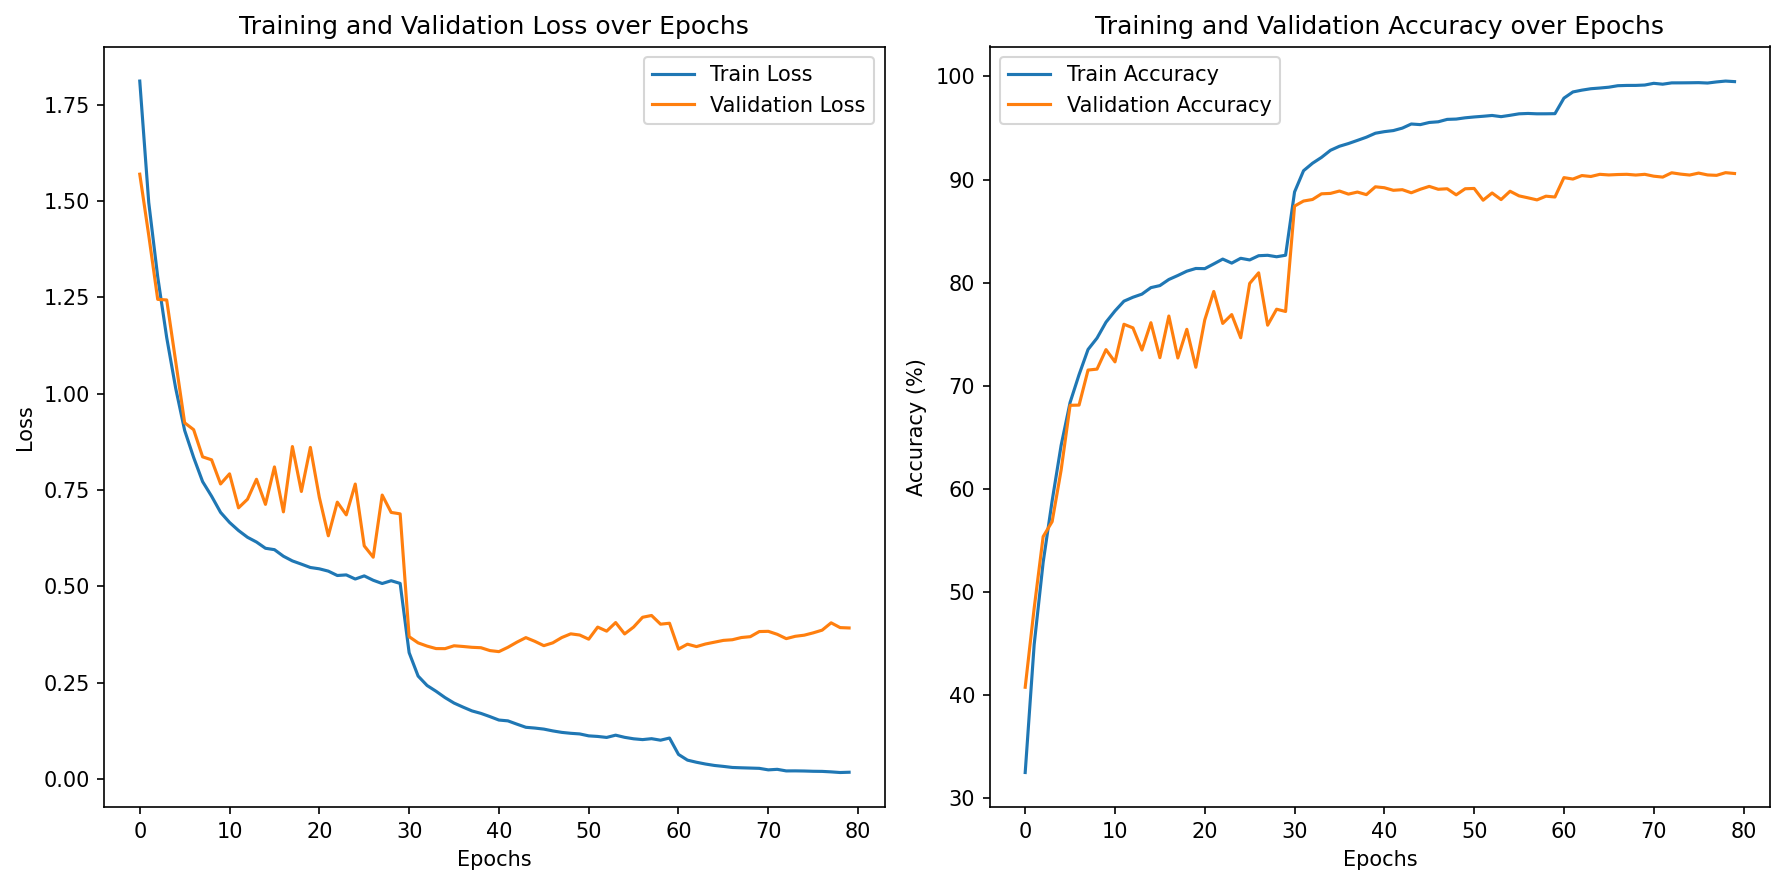

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# TODO: Plot Loss

axes[0].plot(train_loss_list, label='Train Loss')
axes[0].plot(val_loss_list, label='Validation Loss')
axes[0].set_title('Training and Validation Loss over Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# TODO: Plot Accuracy

axes[1].plot(train_accuracy_list, label='Train Accuracy')
axes[1].plot(val_accuracy_list, label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy over Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()

plt.tight_layout()
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `90%`

In [62]:
# TODO: Run Model on Testset

model = ResNet(num_classes=10, feature_space_size=512).to(device)
model.load_state_dict(torch.load("cifar10_NikanVasei.pth"))

model.eval()

correct = 0
total = 0

incorrect_images = []
incorrect_labels = []
incorrect_preds = []

correct_images = []
correct_labels = []
correct_features = []

with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)

        outputs, feature_space = model(images)

        _, predictions = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predictions == labels).sum().item()

        incorrect_idxs = (predictions != labels).nonzero(as_tuple=True)[0]
        for idx in incorrect_idxs:
            incorrect_images.append(images[idx].cpu())
            incorrect_labels.append(labels[idx].cpu().item())
            incorrect_preds.append(predictions[idx].cpu().item())

        correct_idxs = (predictions == labels).nonzero(as_tuple=True)[0]
        for idx in correct_idxs:
            correct_images.append(images[idx].cpu())
            correct_labels.append(labels[idx].cpu())
            correct_features.append(feature_space[idx].cpu())

test_accuracy = 100 * correct / total
print(f"Accuracy on Test Set: {test_accuracy:.2f}%")

100%|██████████| 79/79 [00:04<00:00, 17.23it/s]

Accuracy on Test Set: 90.87%


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model. Note that if you used normalization in the transform function for loading the data, you will need to unnormalize the images before displaying them.

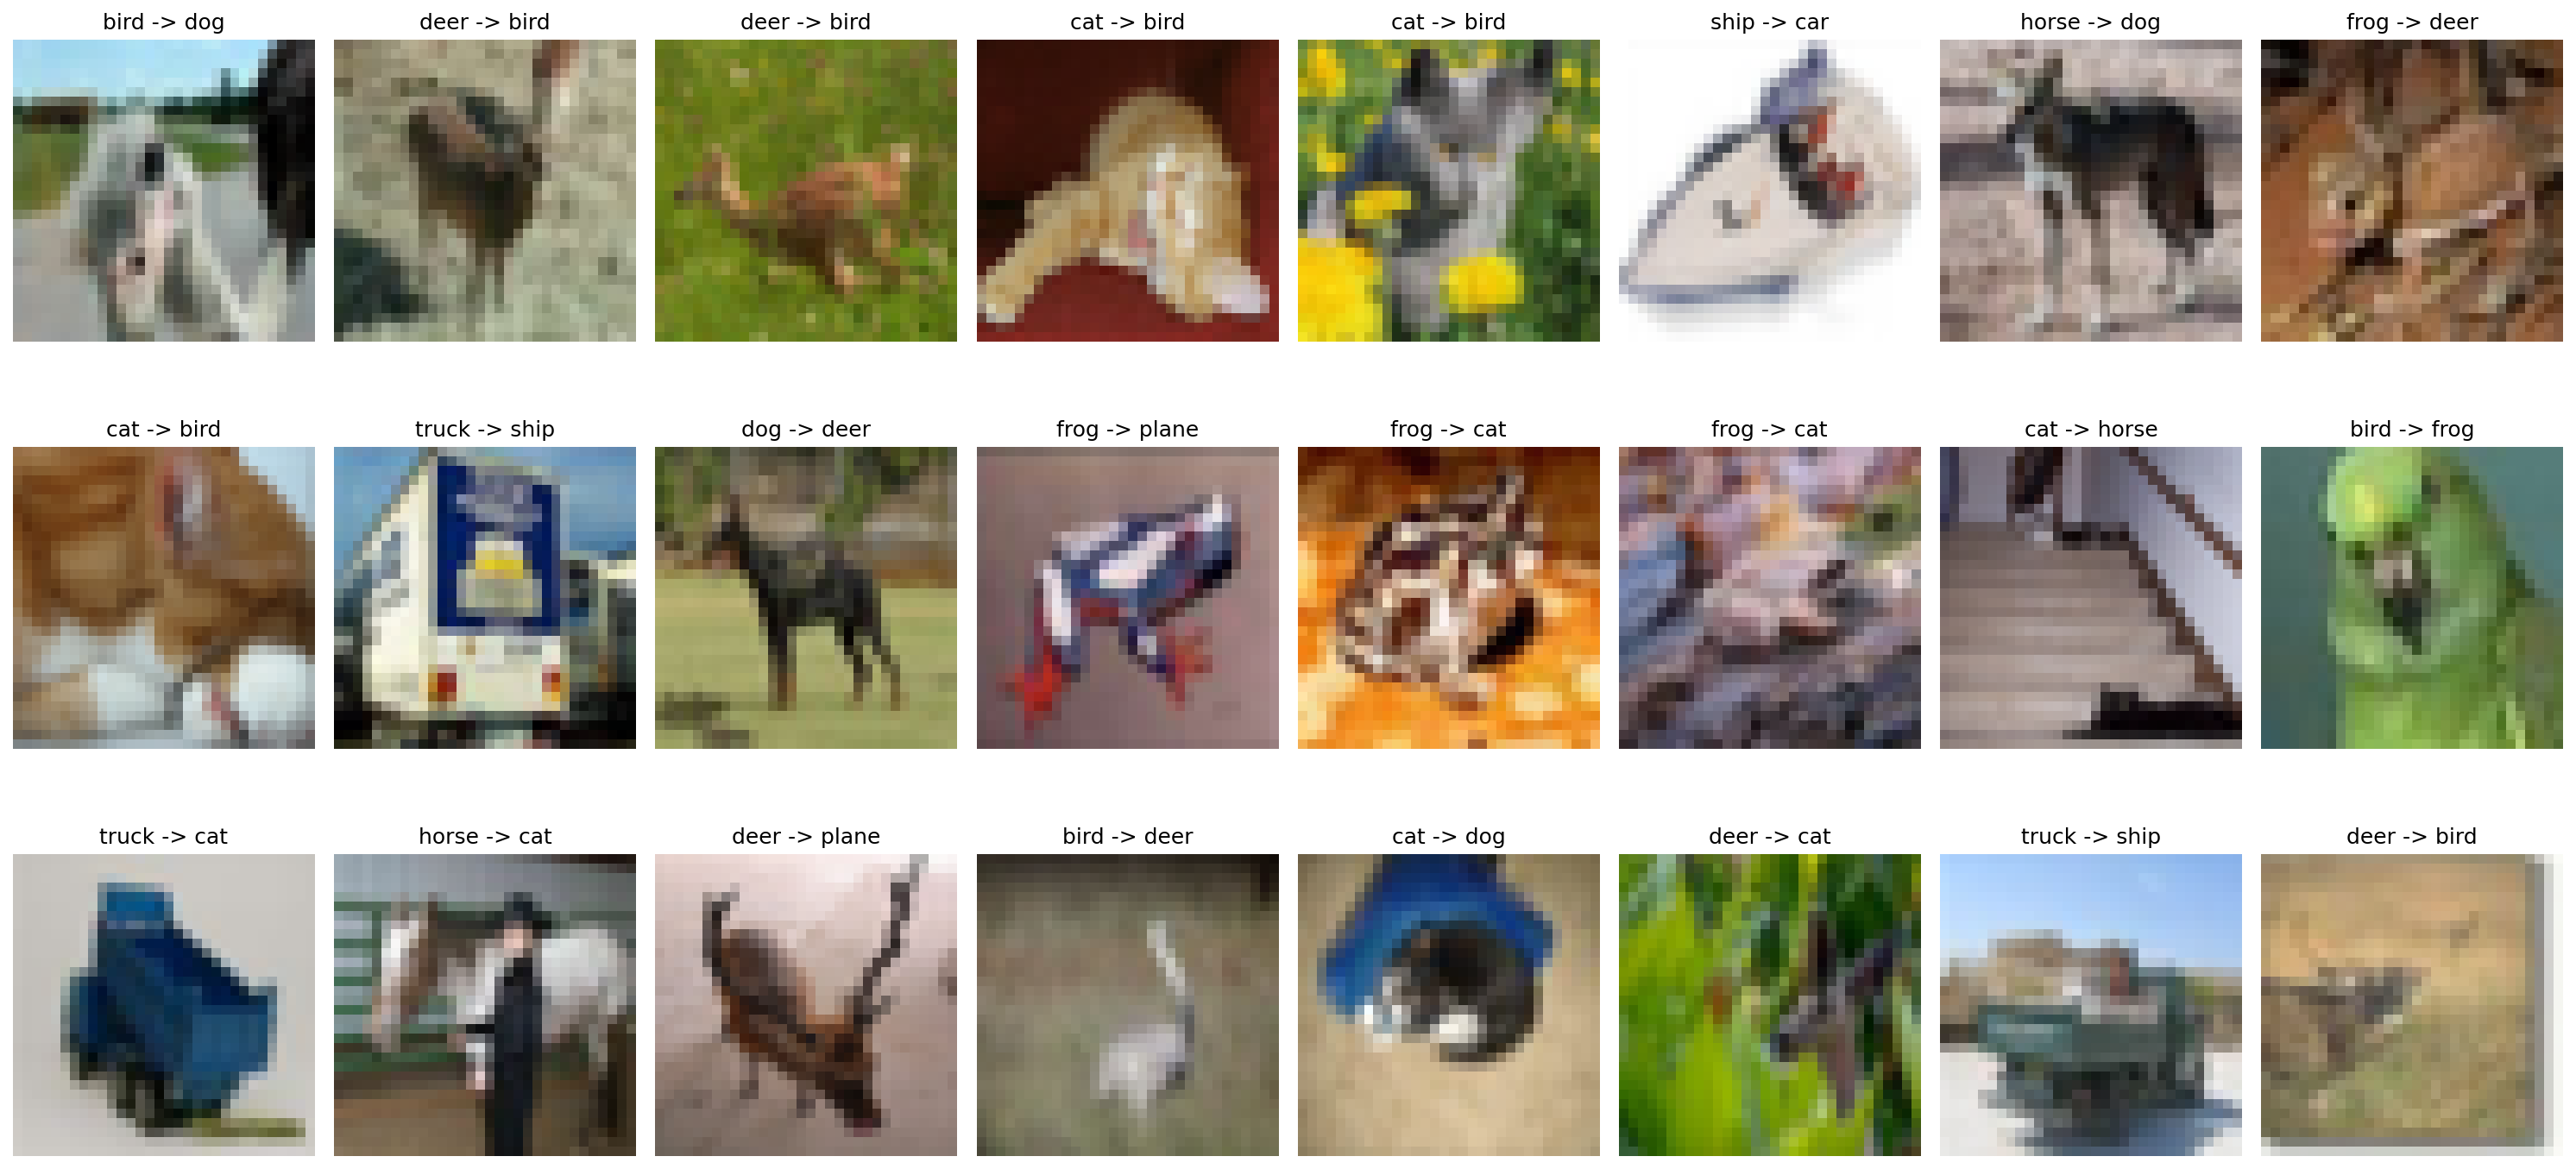

In [63]:
# TODO: Plot Samples with Wrong Predicted Classes

def unnormalize(img, mean, std):
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    return img

selected_idxs = sample(range(len(incorrect_images)), min(24, len(incorrect_images)))

fig, axes = plt.subplots(3, 8, figsize=(20, 10))
axes = axes.flatten()

for i, idx in enumerate(selected_idxs):
    image = unnormalize(incorrect_images[idx], mean, std)
    true_label = classes[incorrect_labels[idx]]
    pred_label = classes[incorrect_preds[idx]]

    image_np = np.transpose(image.numpy(), (1, 2, 0))
    image_np = np.clip(image_np, 0, 1)

    axes[i].imshow(image_np)
    axes[i].axis('off')
    axes[i].set_title(f"{true_label} -> {pred_label}")

plt.tight_layout()
plt.show()

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [64]:
# TODO: Find Features and Put Them in One Dimensional List

train_loader_no_shuffle = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

feature_space_size = 512
train_feature_space = torch.zeros((len(dataset_train), feature_space_size)).to(device)

model.eval()

with torch.no_grad():
    start_idx = 0
    for images, labels in tqdm.tqdm(train_loader_no_shuffle):
        images = images.to(device)

        _, feature_space = model(images)
        train_feature_space[start_idx: start_idx + feature_space.size(0)] = feature_space.cpu()

        start_idx += feature_space.size(0)

print(f"Feature space shape: {train_feature_space.shape}")

100%|██████████| 313/313 [00:16<00:00, 18.93it/s]

Feature space shape: torch.Size([40000, 512])


### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

**Note:** Your visualization should be something like the below picture

**Hint:** To find the nearest neighbors in the feature space, you can use any library of your choice.

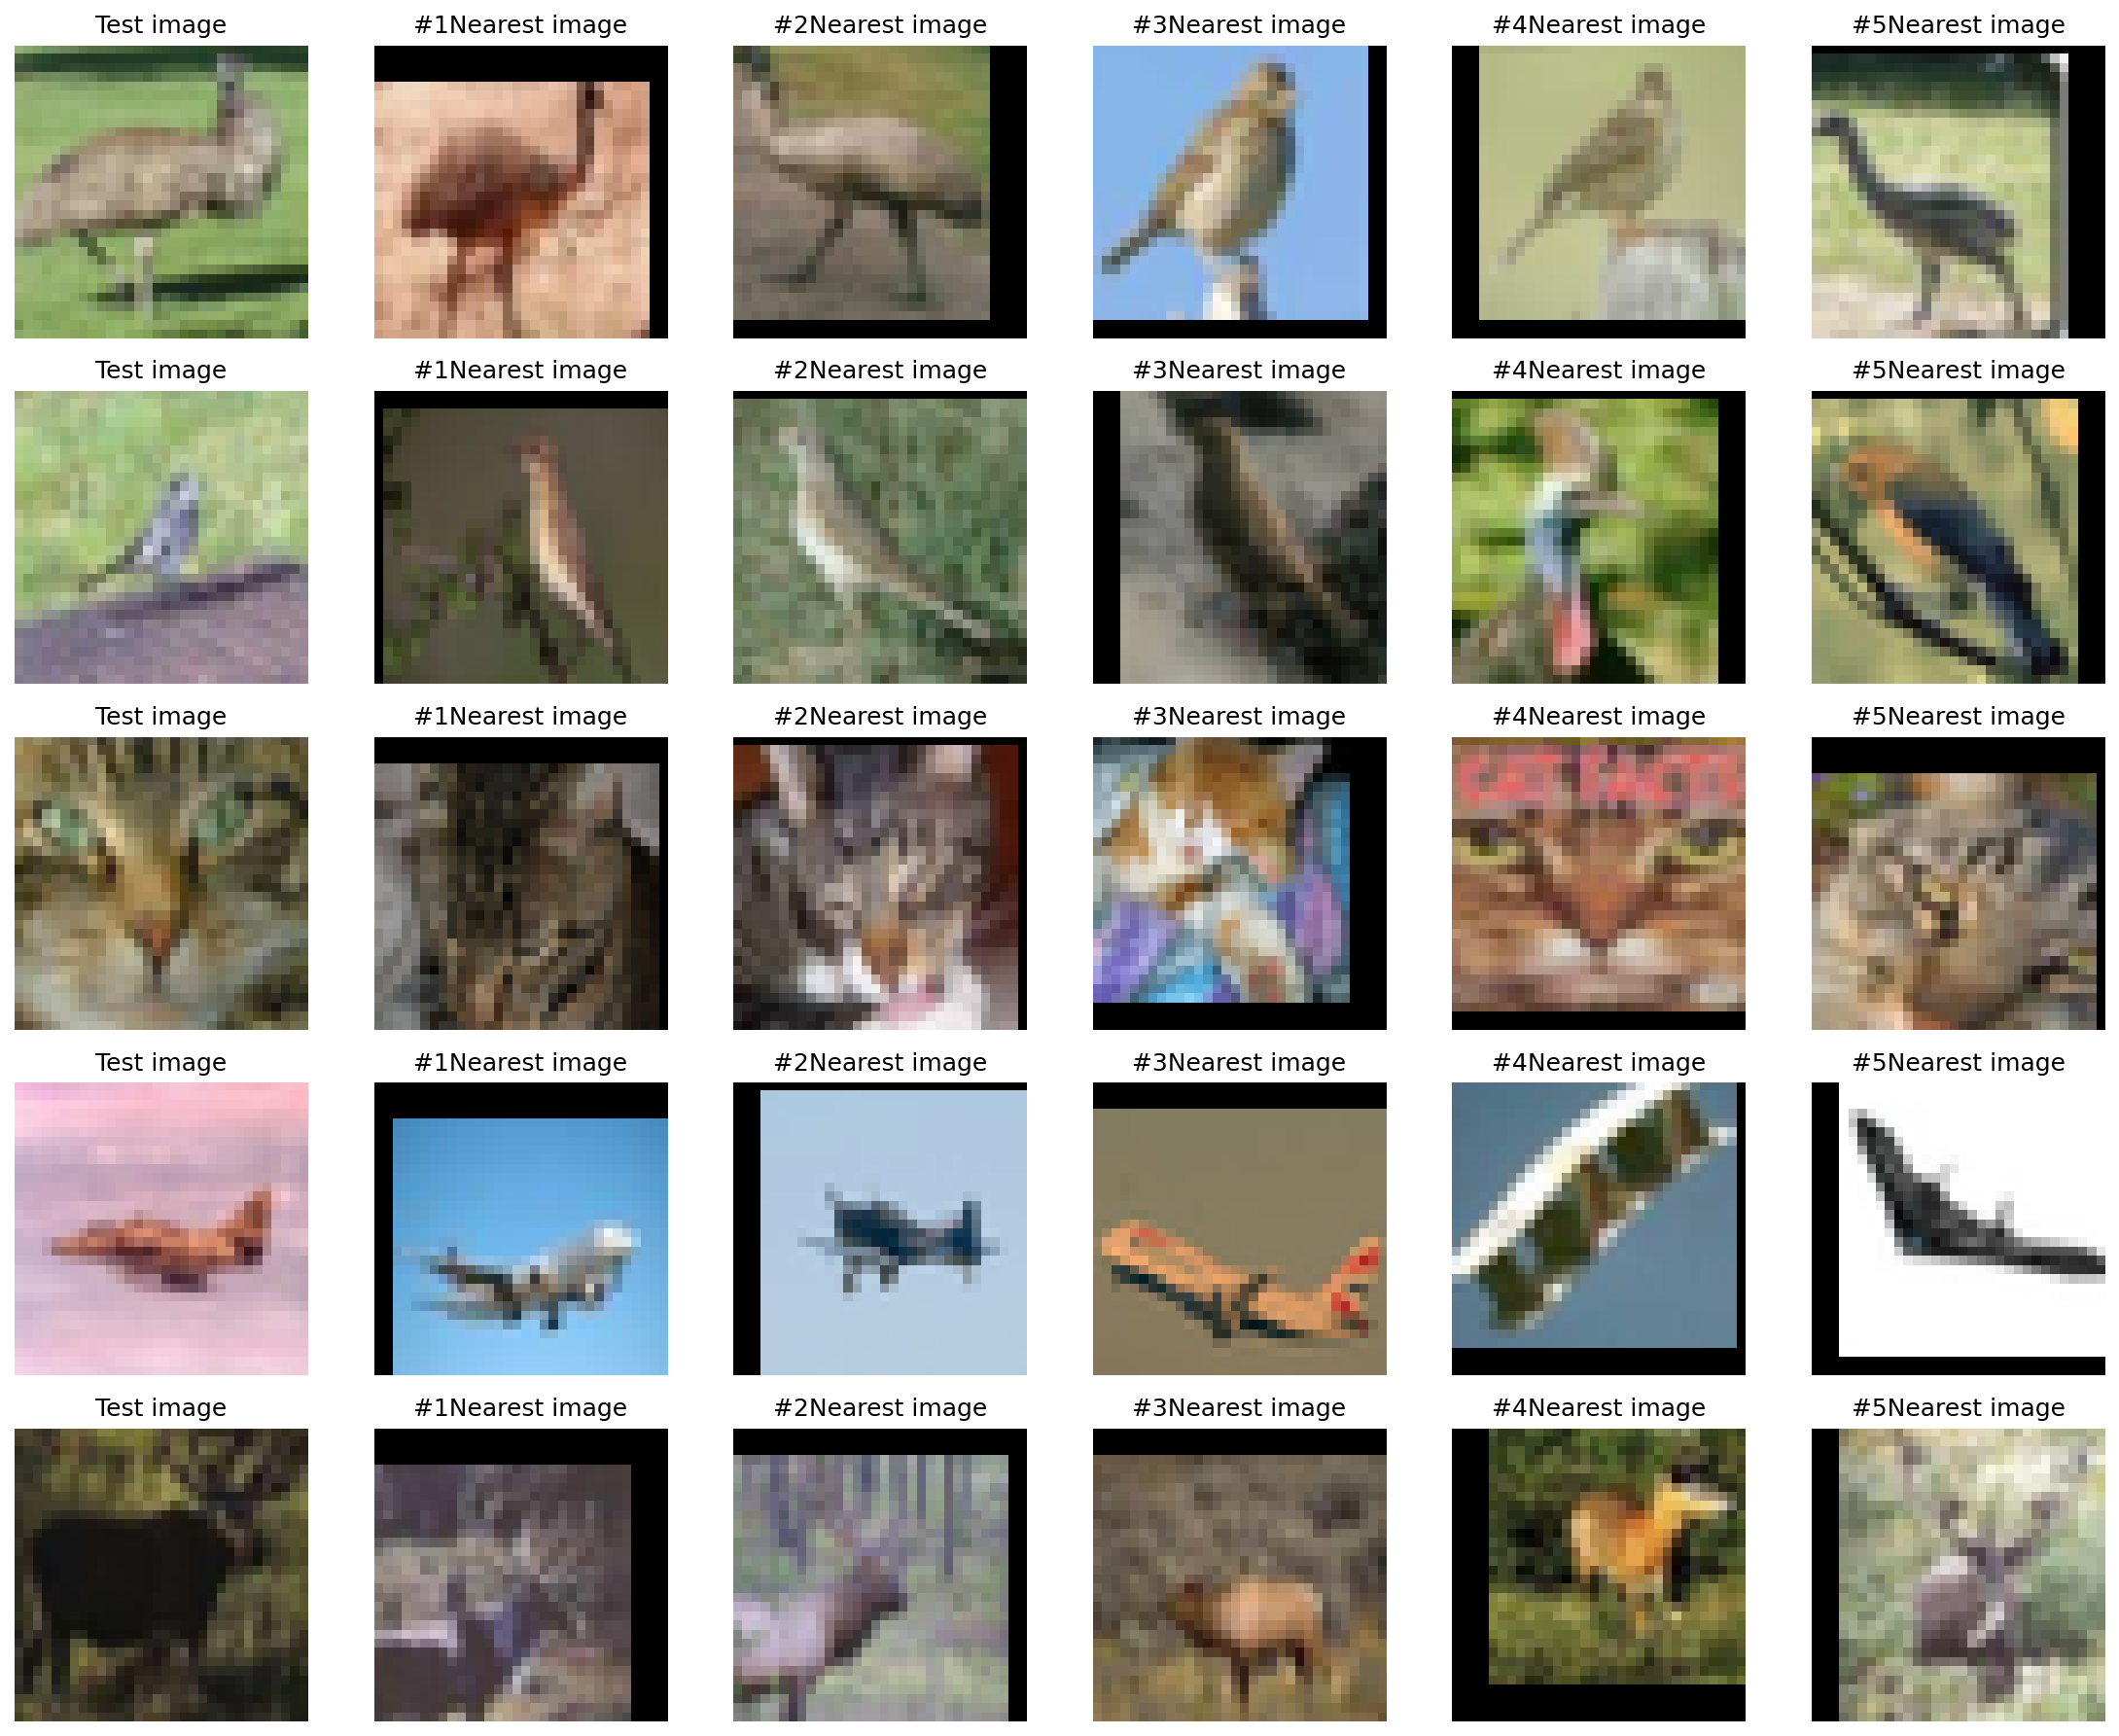

In [65]:
# TODO: Find Features List for Test Samples

sample_indices = sample(range(len(correct_images)), 5)
selected_images = [correct_images[i] for i in sample_indices]
selected_labels = [correct_labels[i] for i in sample_indices]
selected_feature_space = [correct_features[i] for i in sample_indices]

train_feature_space_np = train_feature_space.cpu().numpy()
selected_feature_space_np = torch.stack(selected_feature_space).cpu().numpy()

# Find K Nearest Features

nneighbor = NearestNeighbors(n_neighbors=5, metric='euclidean')
nneighbor.fit(train_feature_space_np)

distances, neighbor_idxs = nneighbor.kneighbors(selected_feature_space_np)

# Plot Features' Images

fig, axes = plt.subplots(5, 6, figsize=(15, 12))

for i in range(5):
    test_img = unnormalize(selected_images[i], mean, std)
    axes[i, 0].imshow(np.transpose(test_img.numpy(), (1, 2, 0)).clip(0, 1))
    axes[i, 0].set_title('Test image')
    axes[i, 0].axis('off')

    for j, neighbor_idx in enumerate(neighbor_idxs[i]):
        neighbor_img, neighbor_label = dataset_train[neighbor_idx]
        neighbor_img = unnormalize(neighbor_img, mean, std)
        axes[i, j + 1].imshow(np.transpose(neighbor_img.numpy(), (1, 2, 0)).clip(0, 1))
        axes[i, j + 1].set_title(f'#{j+1}Nearest image')
        axes[i, j + 1].axis('off')

plt.tight_layout()
plt.show()

### TSNE

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now you a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

In [66]:
# TODO: Get Samples

M = 2000
sample_indices = random.sample(range(len(dataset_train)), M)
sampled_feature_space = train_feature_space[sample_indices].cpu().numpy()
sample_labels = [dataset_train[i][1] for i in sample_indices]

# TODO: Use TSNE

tsne = TSNE(n_components=2, random_state=42)
feature_space_2d = tsne.fit_transform(sampled_feature_space)

print("Shape after TSNE:", feature_space_2d.shape)

Shape after TSNE: (2000, 2)


Visualize the points in a 2D plane (Set color of each point based on it's class)

**Notice:** Your visualization should be something like the below image

**Hint:** Use `plt.scatter(x, y, c=labels)`

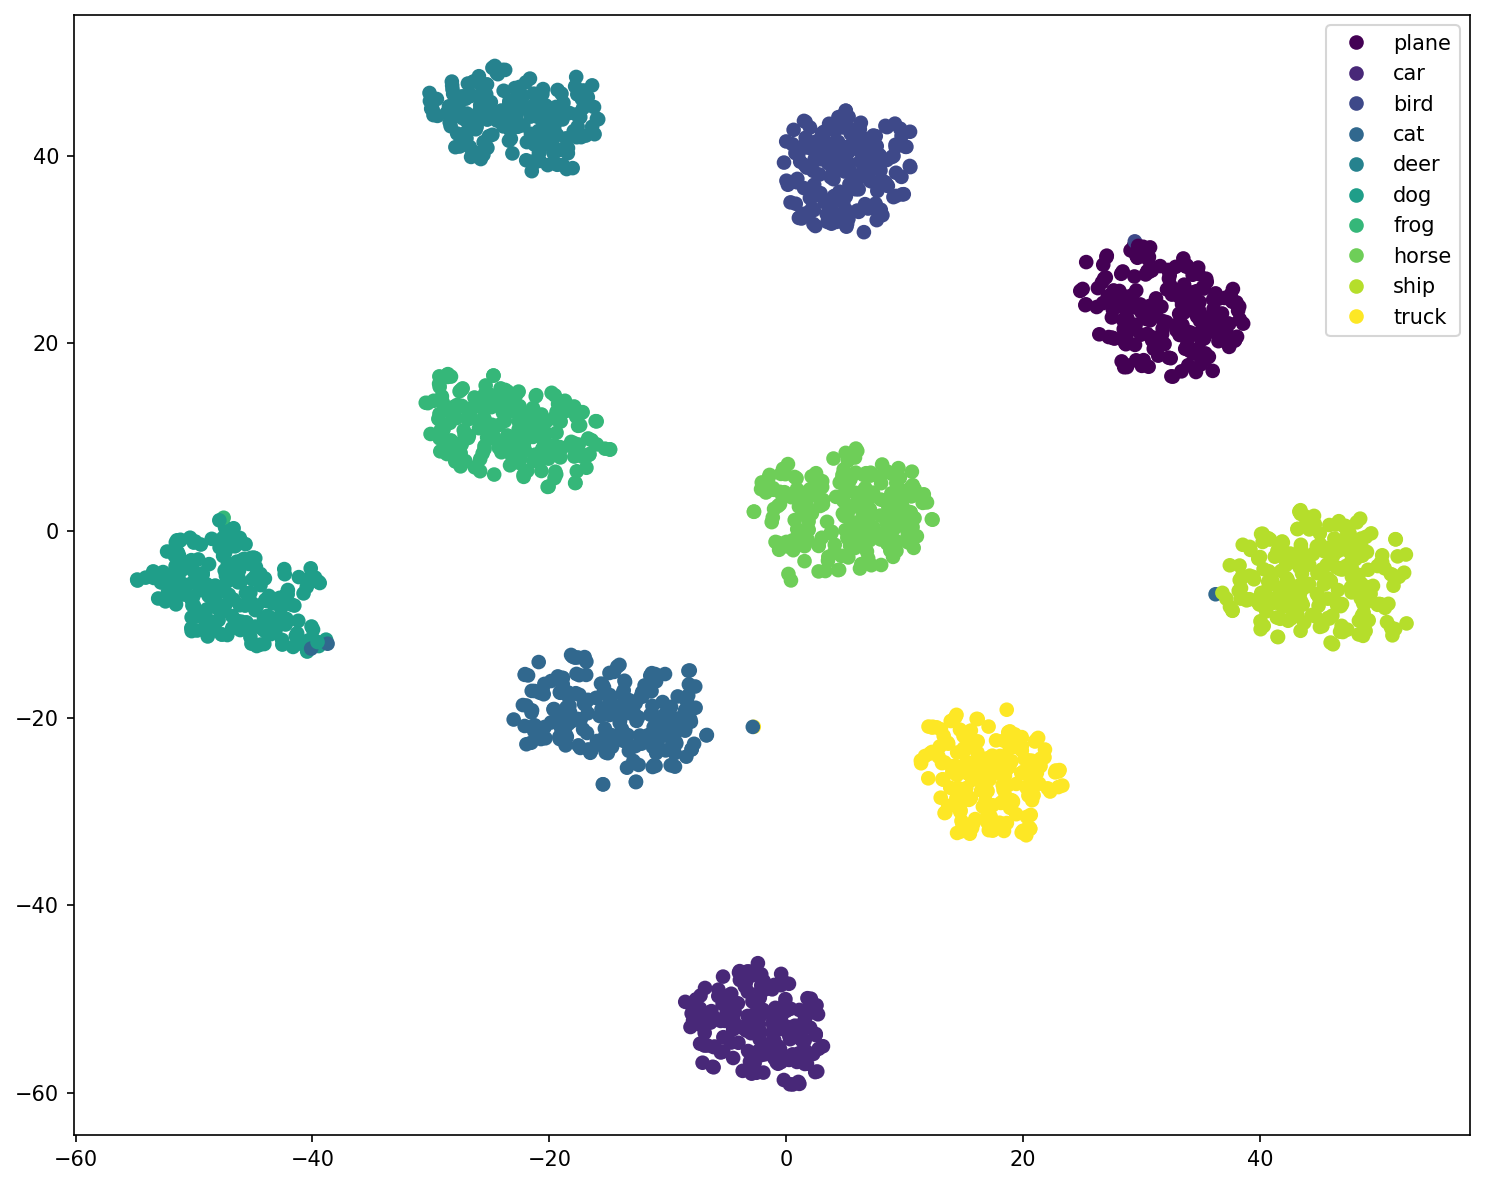

In [67]:
# TODO: Plot Results
plt.figure(figsize=(10, 8))

scatter = plt.scatter(feature_space_2d[:, 0], feature_space_2d[:, 1], c=sample_labels)
handles = scatter.legend_elements()[0]
plt.legend(handles, classes, loc='upper right')

plt.tight_layout()
plt.show()

### Feature Map


In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's select a random image from dataset.

In [68]:
# TODO: Select an Image

random_image, random_label = dataset_train[random.randint(0, len(dataset_train) - 1)]
random_image = random_image.unsqueeze(0).to(device)

Now, we are going to *clip* our model at different points to get different intermediate representation.
* Clip your model at least at one point and plot the filters output. You can use the output of first Resnet block.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 2 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



In [69]:
# TODO: Get Intermediate Output

clipped_model = nn.Sequential(
    model.conv1,
    model.bn1,
    model.relu,
    model.layer1
).to(device)

clipped_model.eval()
with torch.no_grad():
    intermediate_output = clipped_model(random_image)

clipped_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (relu): ReLU()
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

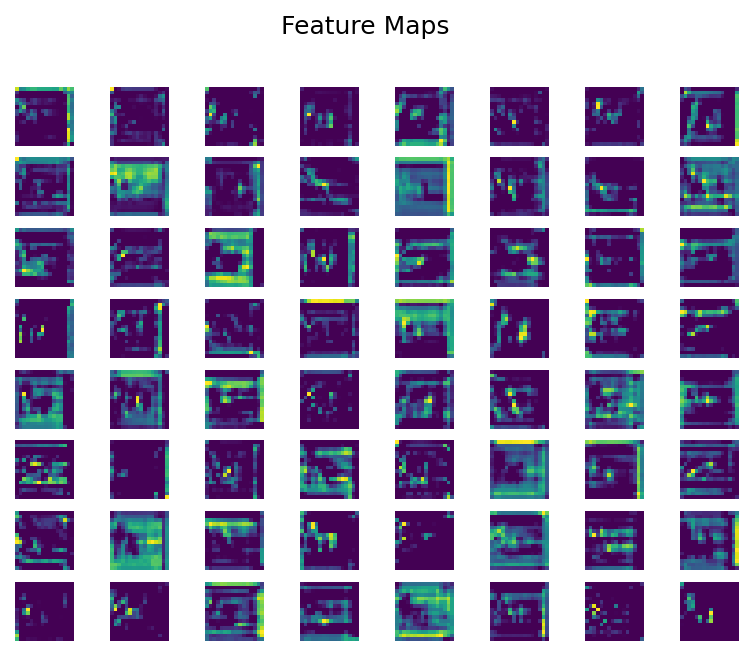

In [70]:
def plot_intermediate_output(result, title=None):
    """ Plots the intermediate output of shape
      N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')

# TODO: Plot Intermediate Output
plot_intermediate_output(intermediate_output, title="Feature Maps")

## CIFAR100

In this section, we aim to test the trained model on a different dataset. For this purpose, we will use the CIFAR100 dataset, which is similar to CIFAR10 but has different types and numbers of classes. In order for the model to perform well on the new dataset, we need to modify the last layer of the model. As you know from the previous section, the last layer of the model is a linear layer that maps the features to the number of classes. In this section, due to the increase in the number of classes, we plan to modify this layer and train the new linear layer with the new dataset. Note that all other layers and weights of the model will remain fixed and unchanged; only the last layer will be retrained.

### Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms.

In [71]:
# TODO: Data Transforms

mean2 = (0.5071, 0.4865, 0.4409)
std2 = (0.2673, 0.2564, 0.2762)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean2, std2),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean2, std2),
])

# TODO: Load Train Data

dataset_raw = torchvision.datasets.CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

dataset_trainval = torchvision.datasets.CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

# TODO: Split Train and Validation Data

train_size = int(0.8 * len(dataset_trainval))

dataset_train, dataset_val = random_split(dataset_trainval, [train_size, len(dataset_trainval) - train_size])

# TODO: Load Test Data

dataset_test = torchvision.datasets.CIFAR100(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

# TODO: Define Data Loaders

BATCH_SIZE = 128

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [72]:
classes = [
    "apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee",
    "beetle", "bicycle", "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", "caterpillar", "cattle", "chair", "chimpanzee",
    "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur", "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster",
    "house", "kangaroo", "keyboard", "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain", "mouse",
    "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree", "plain", "plate", "poppy", "porcupine", "possum",
    "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider",
    "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone", "television", "tiger", "tractor", "train",
    "trout", "tulip", "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"
]
print(len(classes))

100


### Visualization

Visualize 1 random images from each class.

- **Hint**:  You can use `plt.subplots` for visualization

100%|██████████| 100/100 [10:35<00:00,  6.35s/it]


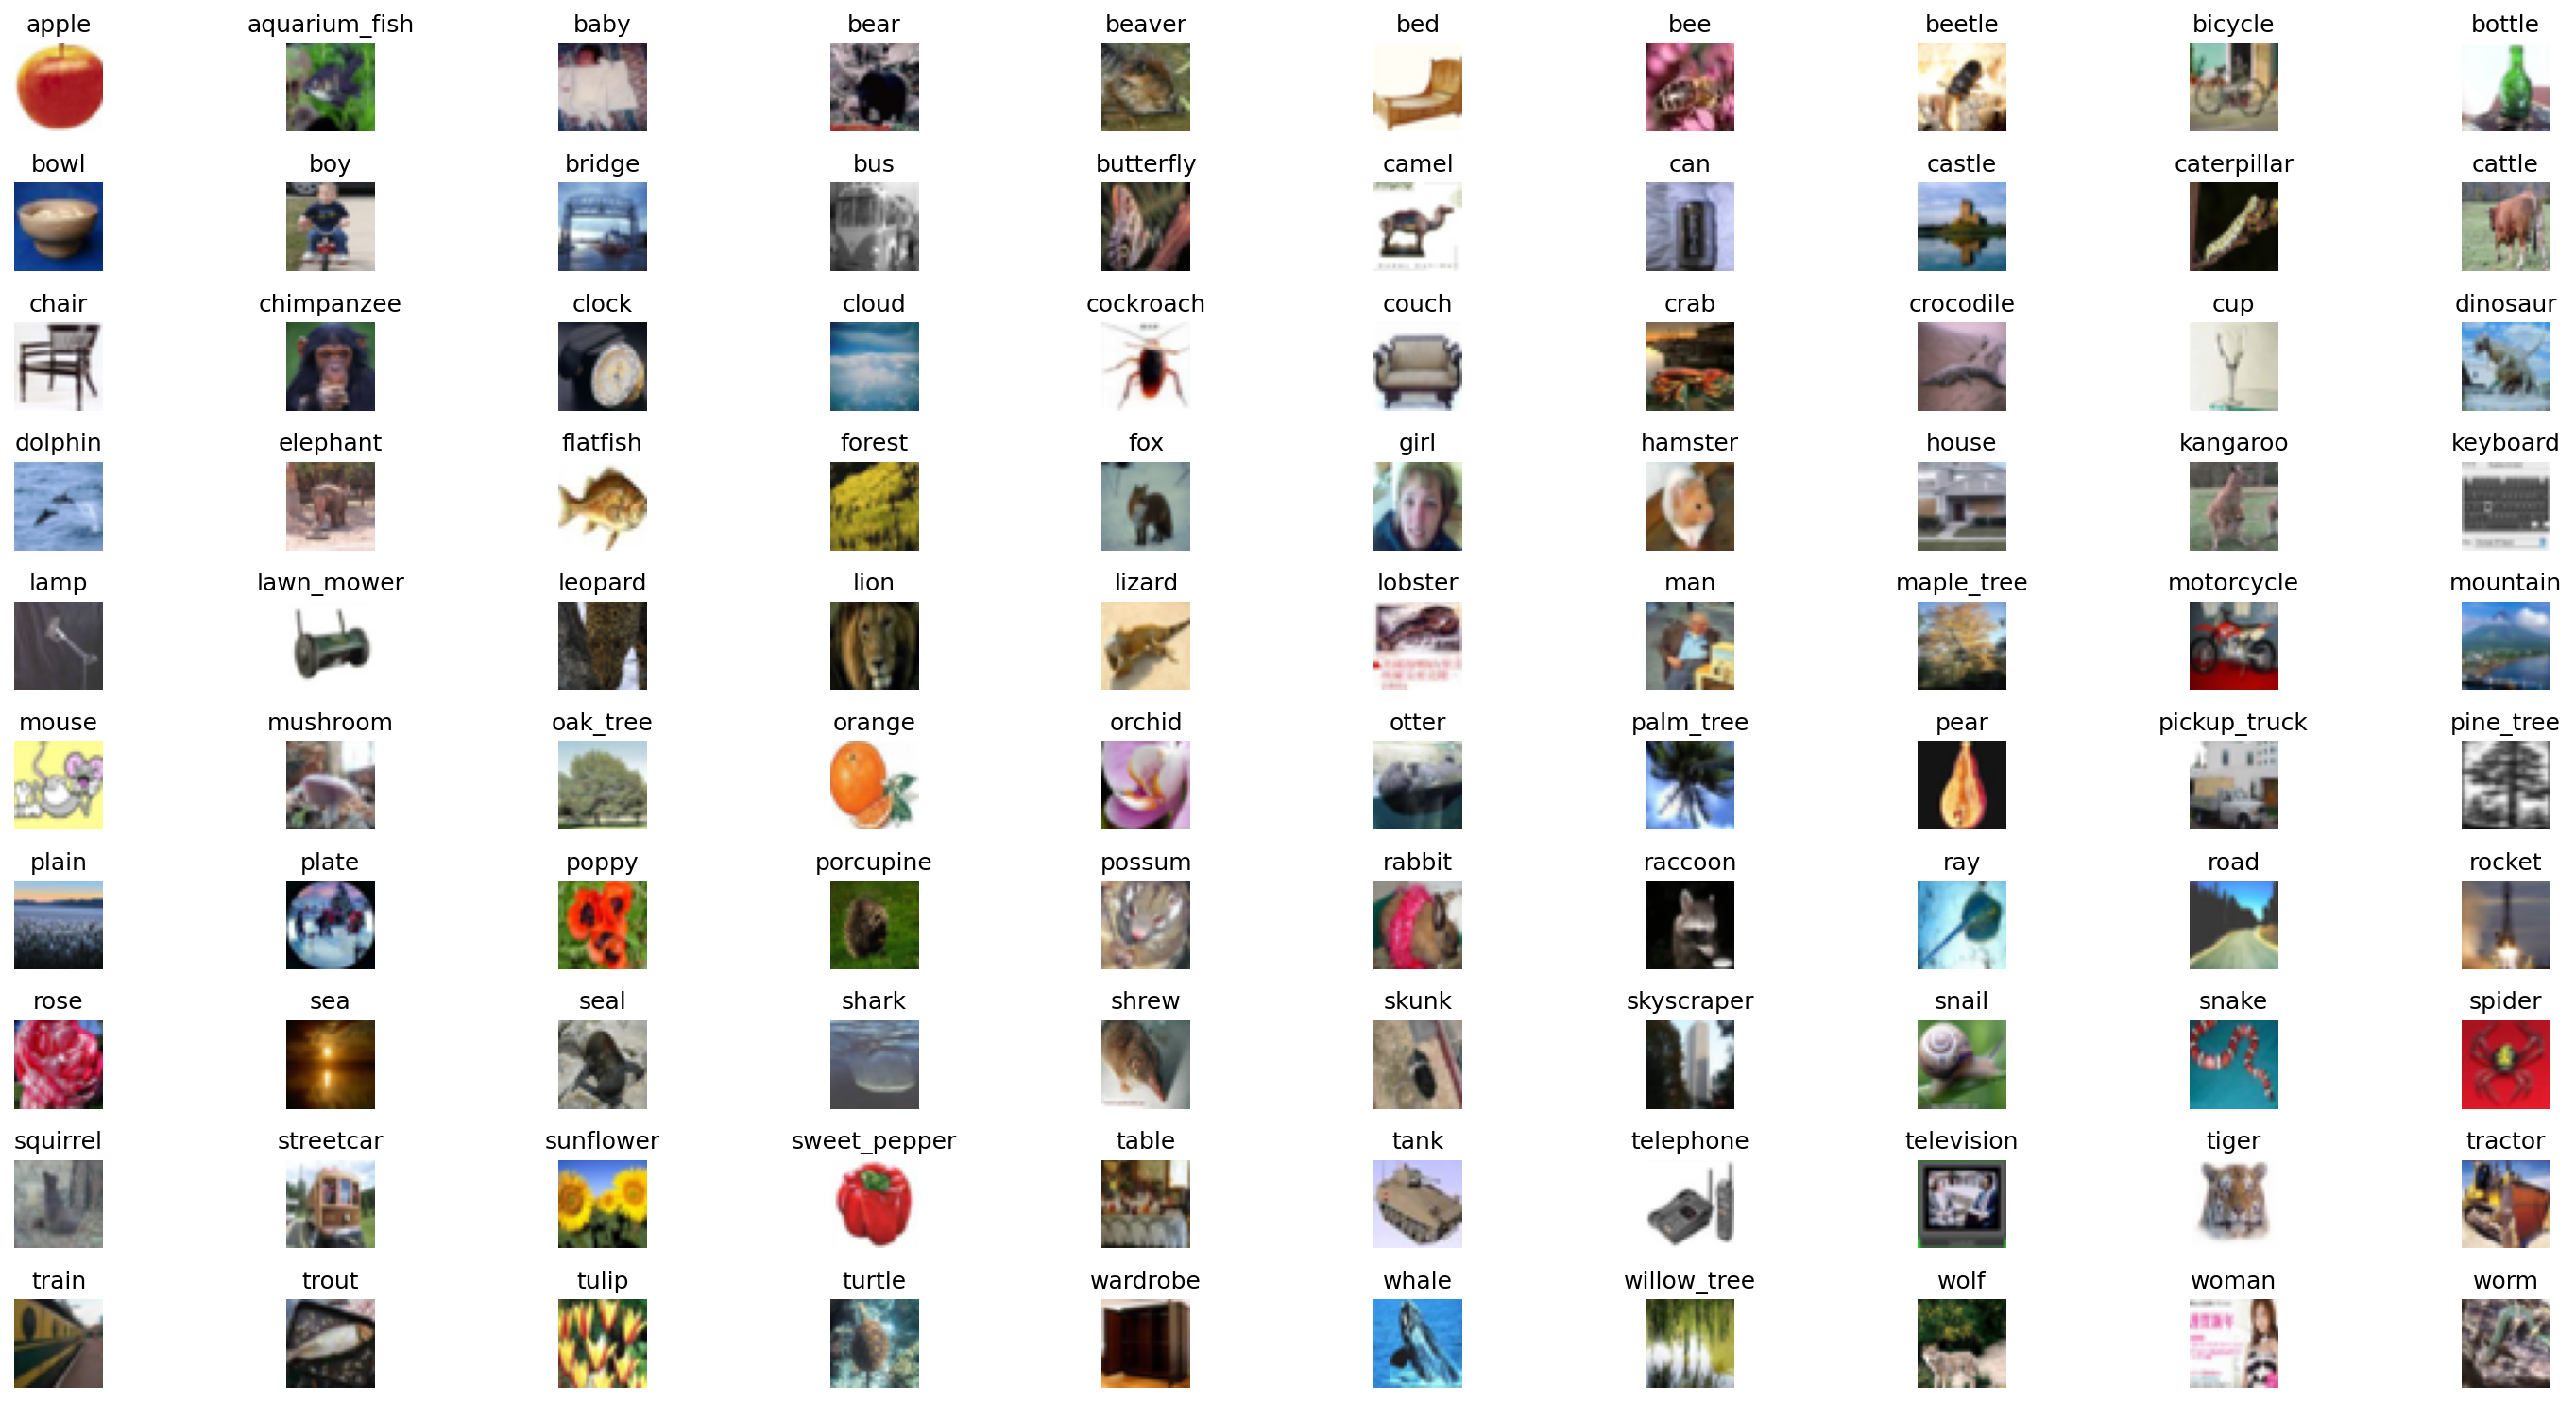

In [73]:
# TODO: Find One Image from Each Class

sample_image_idxs = []
for i, c in enumerate(tqdm.tqdm(classes)):
    class_indices = [idx for idx, (_, label) in enumerate(dataset_raw) if label == i]
    sample_image_idxs.extend(sample(class_indices, 1))

# TODO: Plot Images

fig, axes = plt.subplots(10, 10, figsize=(20, 10))
axes = axes.flatten()

for idx, img_idx in enumerate(sample_image_idxs):
    img, label = dataset_raw[img_idx]
    axes[idx].imshow(img.permute(1, 2, 0).numpy())
    axes[idx].axis('off')
    axes[idx].set_title(classes[idx])

plt.tight_layout()
plt.show()

### Modify Model

Change the final linear layer of the model according to the new number of classes And freeze all other layers.
- Do not forgot to move model to `device`

In [74]:
# Load Pretrained Model

model = ResNet(num_classes=10, feature_space_size=512).to(device)
model.load_state_dict(torch.load("cifar10_NikanVasei.pth"))

# Freeze All Layers

for param in model.parameters():
    param.requires_grad = False

# Modify The Last Linear Layer

model.fc = nn.Linear(model.feature_space.in_features, 100)

# Move Model to Device

model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (relu): ReLU()
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [76]:
# TODO: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

### Train

Train the Model (Only Last Layer)

In [77]:
# TODO: Train The Model

EPOCHS = 20

train_accuracy_list = []
train_loss_list = []

for epoch in range(EPOCHS):
    train_loss, train_accuracy = train_loop(model, train_loader, criterion, optimizer, scheduler)

    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

100%|██████████| 313/313 [00:17<00:00, 17.87it/s]


Epoch [1/20] Loss: 3.8100, Train Accuracy: 10.73%


100%|██████████| 313/313 [00:17<00:00, 17.91it/s]


Epoch [2/20] Loss: 3.7470, Train Accuracy: 11.60%


100%|██████████| 313/313 [00:18<00:00, 16.94it/s]


Epoch [3/20] Loss: 3.7396, Train Accuracy: 11.46%


100%|██████████| 313/313 [00:17<00:00, 18.06it/s]


Epoch [4/20] Loss: 3.7411, Train Accuracy: 11.40%


100%|██████████| 313/313 [00:18<00:00, 16.74it/s]


Epoch [5/20] Loss: 3.7422, Train Accuracy: 11.59%


100%|██████████| 313/313 [00:17<00:00, 18.12it/s]


Epoch [6/20] Loss: 3.7360, Train Accuracy: 11.82%


100%|██████████| 313/313 [00:17<00:00, 17.88it/s]


Epoch [7/20] Loss: 3.7384, Train Accuracy: 11.47%


100%|██████████| 313/313 [00:18<00:00, 16.57it/s]


Epoch [8/20] Loss: 3.7379, Train Accuracy: 11.50%


100%|██████████| 313/313 [00:17<00:00, 17.91it/s]


Epoch [9/20] Loss: 3.7378, Train Accuracy: 11.53%


100%|██████████| 313/313 [00:18<00:00, 16.92it/s]


Epoch [10/20] Loss: 3.7350, Train Accuracy: 11.76%


100%|██████████| 313/313 [00:17<00:00, 17.47it/s]


Epoch [11/20] Loss: 3.7349, Train Accuracy: 11.80%


100%|██████████| 313/313 [00:17<00:00, 17.56it/s]


Epoch [12/20] Loss: 3.7419, Train Accuracy: 11.41%


100%|██████████| 313/313 [00:18<00:00, 17.36it/s]


Epoch [13/20] Loss: 3.7374, Train Accuracy: 11.52%


100%|██████████| 313/313 [00:17<00:00, 18.29it/s]


Epoch [14/20] Loss: 3.7381, Train Accuracy: 11.43%


100%|██████████| 313/313 [00:18<00:00, 17.18it/s]


Epoch [15/20] Loss: 3.7389, Train Accuracy: 11.80%


100%|██████████| 313/313 [00:17<00:00, 17.98it/s]


Epoch [16/20] Loss: 3.7380, Train Accuracy: 11.55%


100%|██████████| 313/313 [00:18<00:00, 17.12it/s]


Epoch [17/20] Loss: 3.7339, Train Accuracy: 11.60%


100%|██████████| 313/313 [00:18<00:00, 17.14it/s]


Epoch [18/20] Loss: 3.7348, Train Accuracy: 11.62%


100%|██████████| 313/313 [00:17<00:00, 18.00it/s]


Epoch [19/20] Loss: 3.7376, Train Accuracy: 11.39%


100%|██████████| 313/313 [00:18<00:00, 17.27it/s]

Epoch [20/20] Loss: 3.7382, Train Accuracy: 11.56%


### Test

Evaluate the Model on CIFAR-100 Test Set. 40% accuracy is sufficient.


In [78]:
# TODO: Evaluate Model on CIFAR100

model.eval()

correct = 0
total = 0

incorrect_images = []
incorrect_labels = []
incorrect_preds = []

correct_images = []
correct_labels = []
correct_preds = []

with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)

        outputs, feature_space = model(images)

        _, predictions = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predictions == labels).sum().item()

        incorrect_idxs = (predictions != labels).nonzero(as_tuple=True)[0]
        for idx in incorrect_idxs:
            incorrect_images.append(images[idx].cpu())
            incorrect_labels.append(labels[idx].cpu().item())
            incorrect_preds.append(predictions[idx].cpu().item())

        correct_idxs = (predictions == labels).nonzero(as_tuple=True)[0]
        for idx in correct_idxs:
            correct_images.append(images[idx].cpu())
            correct_labels.append(labels[idx].cpu().item())
            correct_preds.append(predictions[idx].cpu().item())


# TODO: Print Accuracy

test_accuracy = 100 * correct / total
print(f"Test Accuracy on CIFAR-100: {test_accuracy:.2f}%")

100%|██████████| 79/79 [00:04<00:00, 17.18it/s]

Test Accuracy on CIFAR-100: 12.46%


### Question
You might think that 40% accuracy is quite low. However, first of all, consider that the classification is done over 100 classes. The accuracy of a random model in this case is 1%. Also, we only changed one linear layer of the model, and the rest of the weights remained unchanged. What do you think is the reason the model can achieve a reasonably good generalization ability on a completely new dataset with just the change of one linear layer at the end?

### Answer:

In simple terms we used something called "transferred learning". It means that we used the features that were already extracted from a quite similar dataset (cifar-10) to classify another and more complex dataset (cifar-100). By using the same features, we were able to predict the similar and redundant classes between the datasets (e.g., we could use the features learned from a car to predict a tractor) and also were able to generalize some of them to even predict some unseen classes.

The feature space that we had, had already capture some high-level features and concepts like different shapes, textures etc. and thus by using them it was able to correctly predict that much of the new dataset.

### Visualize incorrectly predicted samples from testset

Visualize *10* random images from testset that are incorrectly predicted by the model

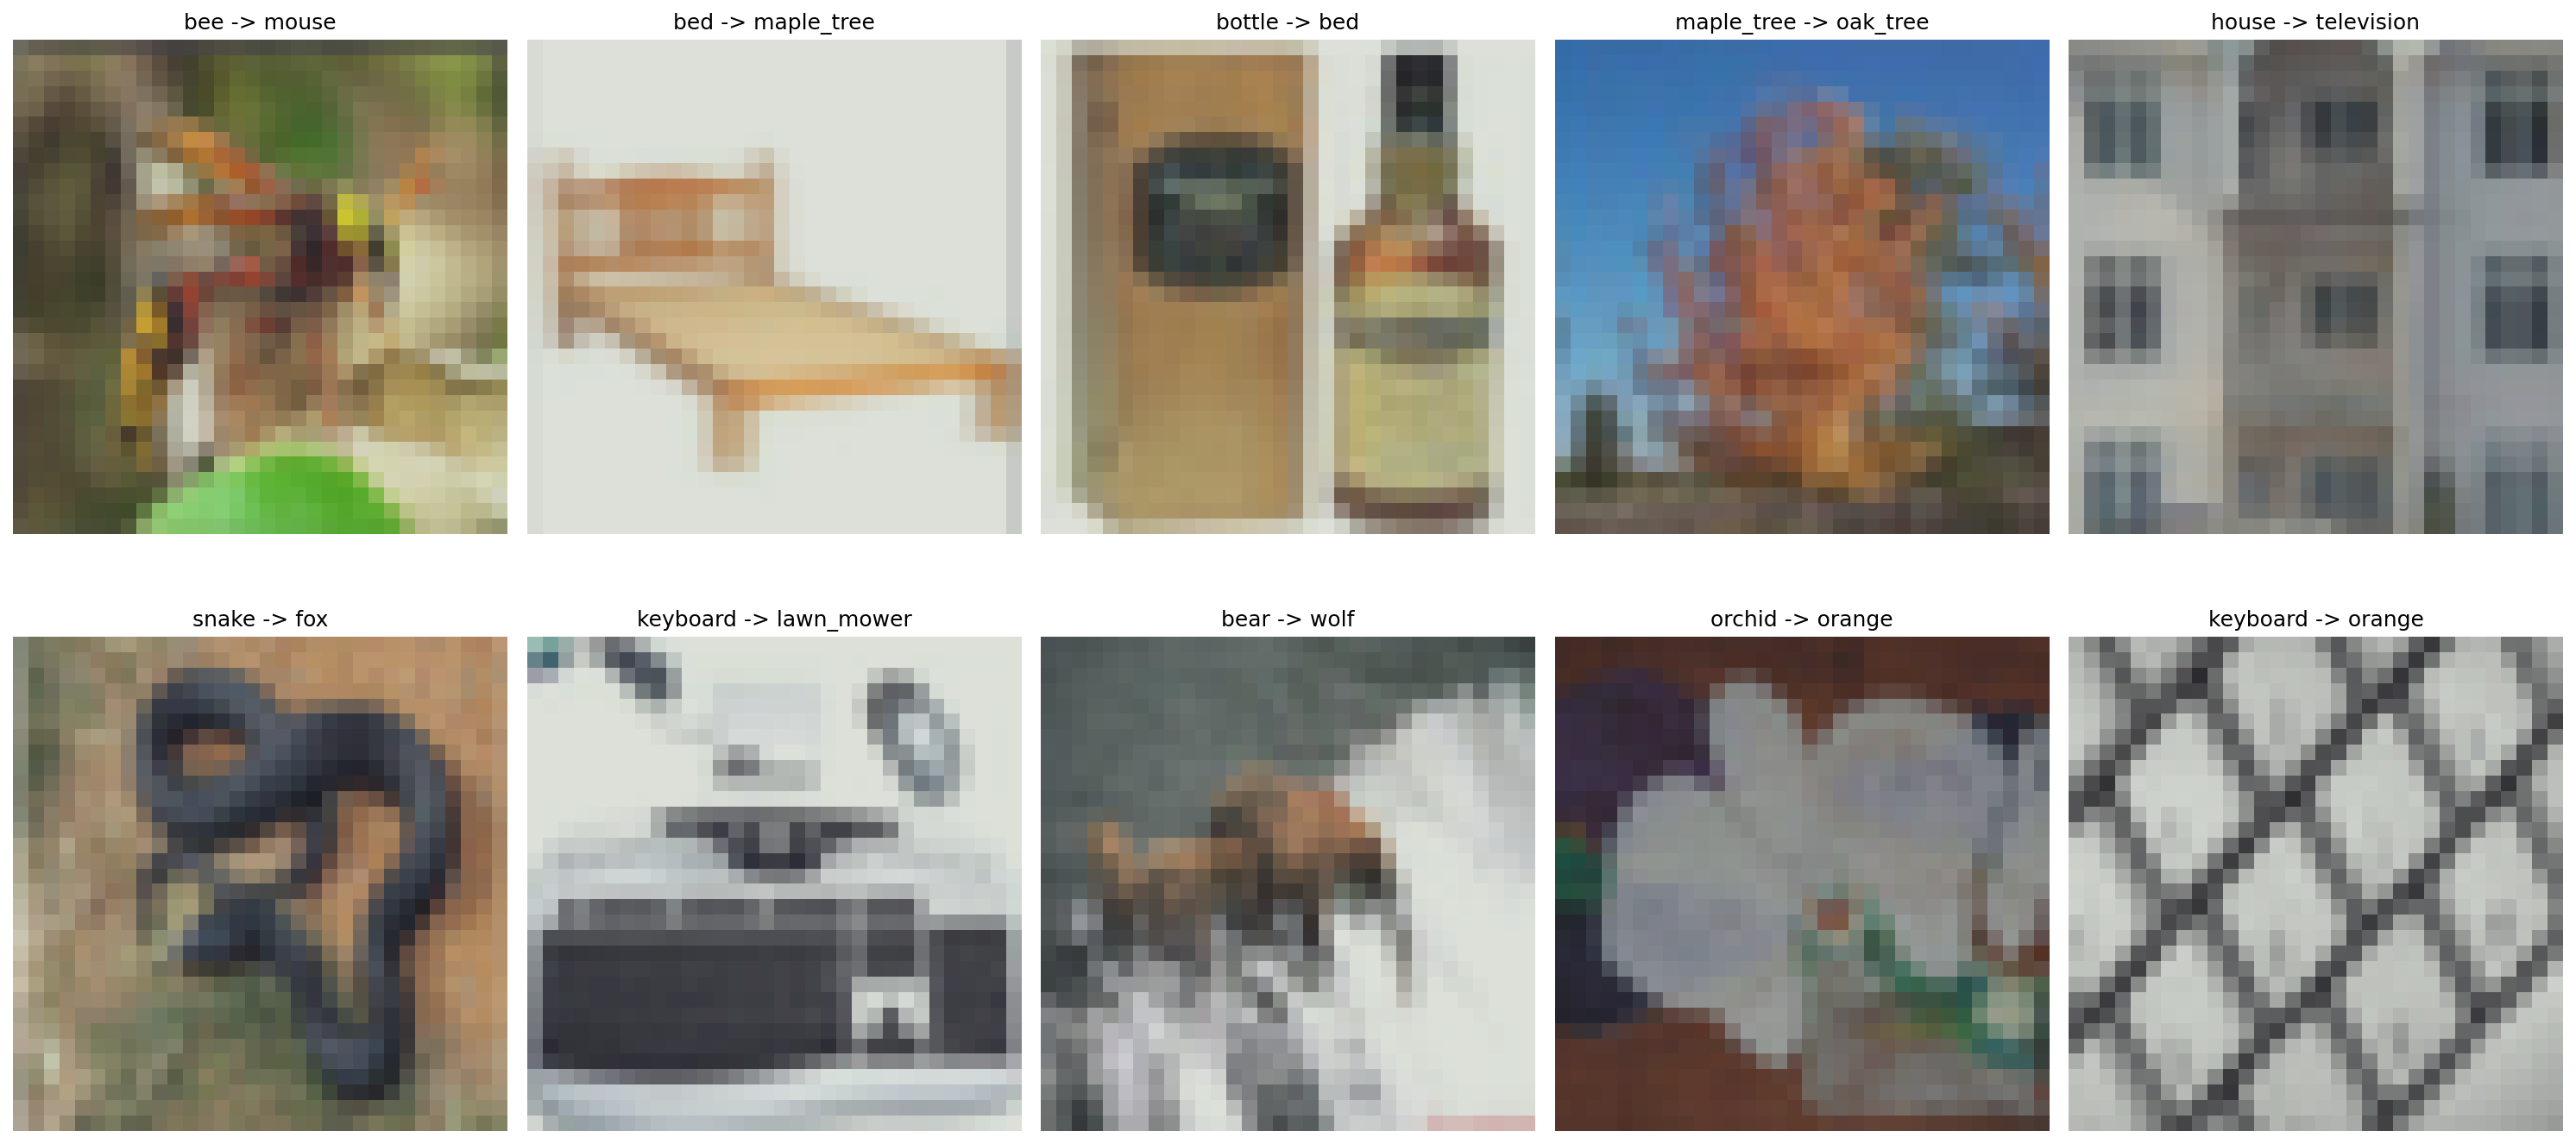

In [79]:
# TODO: Plot Samples with Wrong Predicted Classes

selected_idxs = sample(range(len(incorrect_images)), min(10, len(incorrect_images)))

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for i, idx in enumerate(selected_idxs):
    image = unnormalize(incorrect_images[idx], mean, std)
    true_label = classes[incorrect_labels[idx]]
    pred_label = classes[incorrect_preds[idx]]

    image_np = np.transpose(image.numpy(), (1, 2, 0))
    image_np = np.clip(image_np, 0, 1)

    axes[i].imshow(image_np)
    axes[i].axis('off')
    axes[i].set_title(f"{true_label} -> {pred_label}")

plt.tight_layout()
plt.show()

### Plot accuracy for each class

Plot accuracy of model on testset for each class.

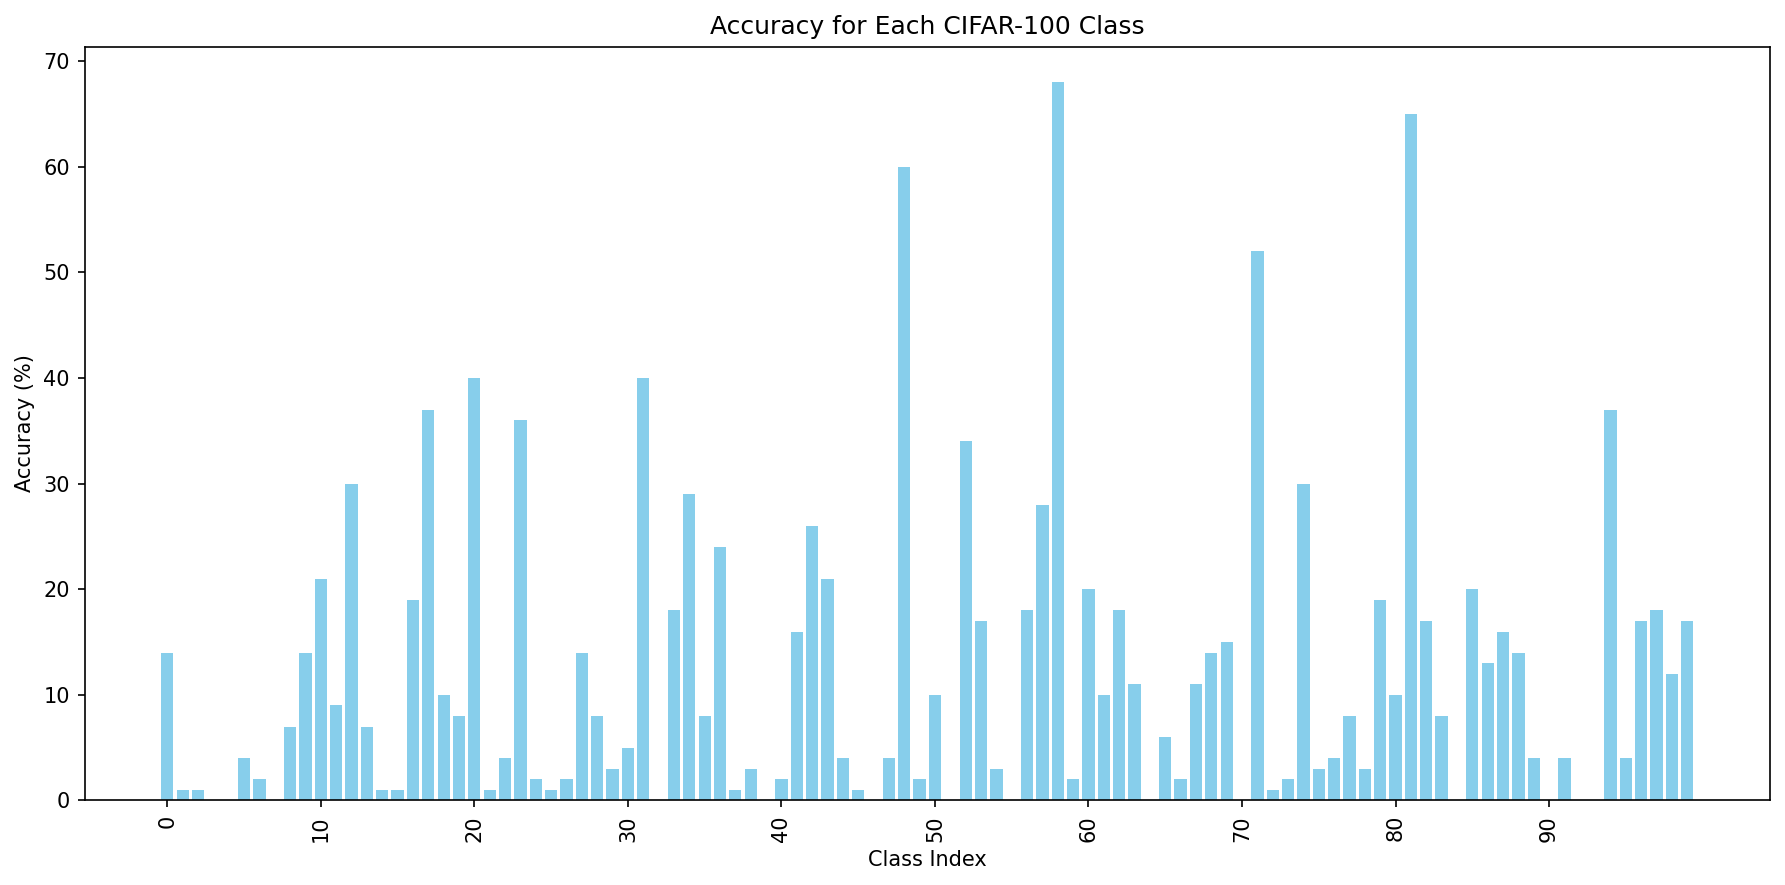

In [80]:
# TODO: Calculate Accuracy for Each Class

class_wise_correct = np.zeros(100)
class_wise_total = np.zeros(100)

for i, label in enumerate(correct_labels):
    class_wise_correct[label] += 1
    class_wise_total[label] += 1

for i, label in enumerate(incorrect_labels):
    class_wise_total[label] += 1

class_wise_accuracy = class_wise_correct / class_wise_total * 100

# TODO: Plot Class-Wise Accuracy

plt.figure(figsize=(12, 6))
plt.bar(range(100), class_wise_accuracy, color='skyblue')

plt.xlabel('Class Index')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for Each CIFAR-100 Class')
plt.xticks(range(0, 100, 10), rotation=90)

plt.tight_layout()
plt.show()

### The classes with the best and worst accuracy

Based on the results from the previous section, obtain the 5 classes with the best accuracy and the 5 classes with the worst accuracy on the testset, and display one sample from each of them.

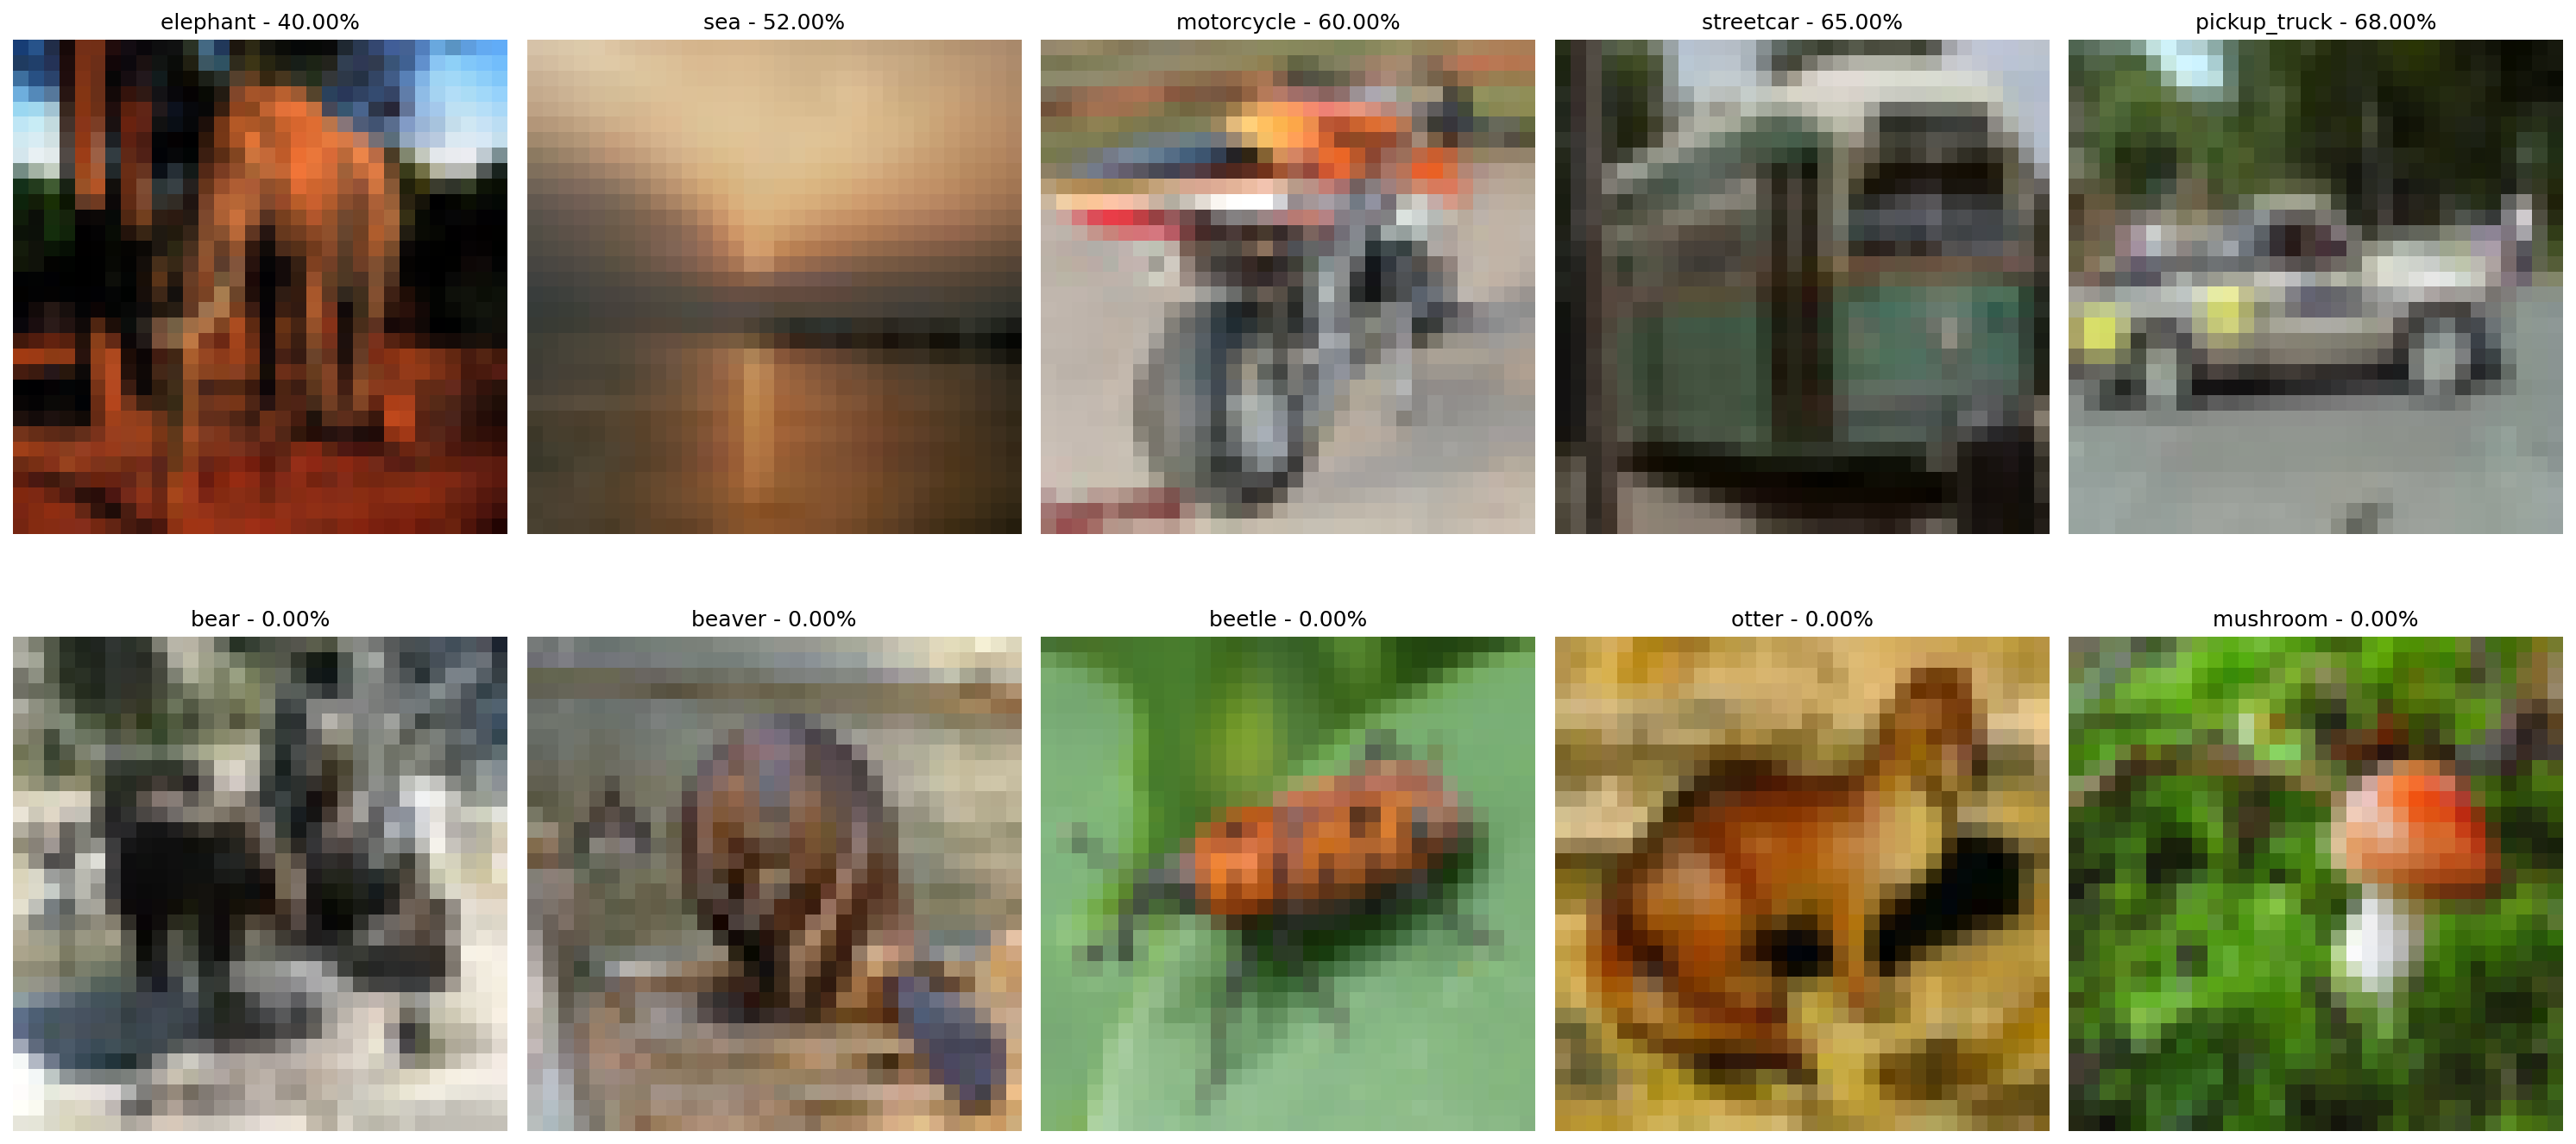

In [81]:
# TODO: Find Top 5 Best and Worst Performing Classes

best_classes = np.argsort(class_wise_accuracy)[-5:]
worst_classes = np.argsort(class_wise_accuracy)[:5]

# Plot a Sample Image From Each of The Best and Worst Performing Classes

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for i, class_idx in enumerate(best_classes):
    class_indices = [idx for idx, (_, label) in enumerate(dataset_test) if label == class_idx]
    image, label = dataset_test[random.choice(class_indices)]

    image_unnorm = unnormalize(image, mean2, std2)
    axes[i].imshow(np.transpose(image_unnorm.numpy(), (1, 2, 0)).clip(0, 1))
    axes[i].set_title(f"{classes[class_idx]} - {class_wise_accuracy[class_idx]:.2f}%")
    axes[i].axis('off')

for i, class_idx in enumerate(worst_classes):
    class_indices = [idx for idx, (_, label) in enumerate(dataset_test) if label == class_idx]
    image, label = dataset_test[random.choice(class_indices)]

    image_unnorm = unnormalize(image, mean2, std2)
    axes[i + 5].imshow(np.transpose(image_unnorm.numpy(), (1, 2, 0)).clip(0, 1))
    axes[i + 5].set_title(f"{classes[class_idx]} - {class_wise_accuracy[class_idx]:.2f}%")
    axes[i + 5].axis('off')

plt.tight_layout()
plt.show()

### Question
What do you think is the reason for the significant accuracy difference between different classes? What differences do you observe between the classes with the best and worst accuracy? Can you provide an analysis of the results and relate them to the model’s feature space?

### Answer:

#### Part1:

There are multiple things that we need to consider here.
- Complexity of different classes: First thing first, is the complexity of different classes. Some classes are more complex than the others, e.g., an image of a crab is definitely more complex than an image of a sea, and thus the model needs to learn more features from them (within the same number of epochs) in order to be as accurate as the simpler ones on them. Obviously this is not possible (in most cases) and thus our model predicts the more complex classes with less accuracy.

- Similarity of different classes: As we can see, some classes are quite similar (e.g., a car and a tractor) and thus our model can use the things that it learns on either of them to get more accurate on predicting both of them (e.g., both cars and tractors have doors, thus our model can use the learned features about doors in cars, to predict doors in tractors, etc.). This thing can be both helpful and also dangerous, because sometimes two images from two different classes are so similar that our model classifies them wrong (e.g. predicts a tractor to be a car), this occurs because the learned features from those classes are quite similar and thus our model can't distinguish between them properly.

#### Part2:

From the images above, we can see that the classes with the most accuracy are the classes that are both quite simple and also quite unique (e.g., seas are quite unique and are not that similar to other classes). On the other hand, the classes with the worst accuracies are quite complex and also they are somewhat similar to each other (in some cases) and thus it makes the difficult to predict.

#### Part3:

To conclude, we can say that based on the images above and also the feature space that we saw in the previous part, our model has some degree of generalization to it, and was able to learn some useful features that were both helpful in predicting the cifar-10 and cifar-100 datasets. Of course it wasn't as good as the cifar-10 in predicting cifar-100 and failed to predict some of the new and more complex classes (because of the reasons mentioned in Part1 it wasn't able to learn those new features that much) but still it was able to predicting some of its classes with very high accuracies. In terms of feature space, the model was able to make a quite perfect 10-cluster space to predict the classes in cifar-10, but wasn't able to make a quite well and clean 100-cluster space in order to classify the cifar-100 classes and thus lost some accuracy on that dataset.